# 1) Library Set Up

In [1]:
# Cloud-based Install
# !pip install tweet-preprocessor --quiet
# !pip install Sastrawi --quiet
# !pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git --quiet
# !pip install Levenshtein --quiet
# !pip install deep-translator --quiet
# !pip install wordcloud --quiet
# !pip install nlp-id --quiet 
# !pip install scikit-plot --quiet
# !pip install yellowbrick --quiet
# !pip install scikit-optimize --quiet
# !pip install optuna --quiet
# !pip install imbalanced-learn --quiet
# !pip install gensim --quiet
# !pip install pymongo --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [ ]:
# Cloud-based Install
# !pipenv install tweet-preprocessor --quiet
# !pipenv install Sastrawi --quiet
# !pipenv install git+https://github.com/ariaghora/mpstemmer.git --quiet
# !pipenv install Levenshtein --quiet
# !pipenv install deep-translator --quiet
# !pipenv install wordcloud --quiet
# !pipenv install nlp-id --quiet 
# !pipenv install scikit-plot --quiet
# !pipenv install yellowbrick --quiet
# !pipenv install scikit-optimize --quiet
# !pipenv install optuna --quiet
# !pipenv install imbalanced-learn --quiet
# !pipenv install gensim --quiet
# !pipenv install pymongo --quiet
# !pipenv install tqdm --quiet

In [8]:
# Libraries Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import preprocessor as p
import re
import string
import nltk
import ast
import optuna
import warnings
import pickle
import joblib
import gensim
import math
import tqdm
import xgboost as xgb
import cupy as cp
import copy

from plotly import graph_objs as go

from itertools import chain

from pprint import pprint

from deep_translator import GoogleTranslator

from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.naive_bayes import *
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from wordcloud import WordCloud

from tqdm import tqdm

from IPython.display import display # To display visually formatted dataframe

from yellowbrick.model_selection import LearningCurve, learning_curve
from yellowbrick.classifier import confusion_matrix

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

from collections import Counter
from pymongo import MongoClient

In [9]:
# Pandas Config
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

In [10]:
# Enabling Progress Bar For Pandas
tqdm.pandas()

In [11]:
# Ignore Optuna's Tuple Parameter Space Warning
warnings.filterwarnings("ignore", message="Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains", category=UserWarning)
# Set optuna verbosity level to only warning
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [12]:
# Displaying all elements of numpy aray
np.set_printoptions(threshold=np.inf)

In [13]:
# Plotly workaround
import plotly.io as pio
pio.renderers.default = 'iframe'

In [14]:
# Login wandb
import wandb
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

# 2) Loading Data

**Deskripsi**

Asal Artikel: [Emotion dataset from Indonesian public opinion](https://www.sciencedirect.com/science/article/pii/S2352340922006588)

Asal Dataset: [Dataset Emosi](https://github.com/Ricco48/Emotion-Dataset-from-Indonesian-Public-Opinion)

Dataset ini terdiri dari tweet opini publik di Indonesia tentang berbagai topik. Data ini berlabel tunggal, dengan enam label emosional: kemarahan, ketakutan, kegembiraan, cinta, sedih, dan netral (label original berbahasa inggris).

Berikut merupakan distribusi dataset.

![distribusi](assets/distribusi.png)


In [10]:
df = pd.read_csv("dataset/merge-csv.com__667bb9a668de3.csv", 
                 sep='\t',
                 encoding='utf-8')
df.head(1)

Tweet  \
0  akibat dari telat bangun, anak ikut bangun dan dapur dan rumah tidak kepegang sampe jam segini. sedih karena berantakan, tp gppa dehh penting anak dah mandi dan kenyang dulu. alon-alon asal kelakon   

  Label  
0   Sad

In [47]:
en_id_mapping = {
    "Neutral":"Netral",
    "Joy":"Bahagia",
    "Anger":"Marah",
    "Sad":"Sedih",
    "Fear":"Takut",
    "Love":"Cinta"
}
df["Label"] = df["Label"].map(en_id_mapping)
df["Label"].value_counts()

Label
Netral     2000
Bahagia    1275
Marah      1130
Sedih      1002
Takut       911
Cinta       760
Name: count, dtype: int64

# 3) EDA

## **Basic Info (Row & Column Info)**

---

In [48]:
# Basic Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7078 entries, 0 to 7077
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet       7078 non-null   object
 1   Label       7078 non-null   object
 2   word_count  7078 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 166.0+ KB


## **Checking Duplicates**


---

In [12]:
# Checking duplicates
df.duplicated(subset="Tweet").sum()

62

## **Checking Missing Values**

---

In [13]:
# Checking missing values in tweets
df["Tweet"].isnull().sum()

0

In [14]:
# Checking missing values in labels
df["Label"].isnull().sum()

0

## **Checking Label Distribution**

---

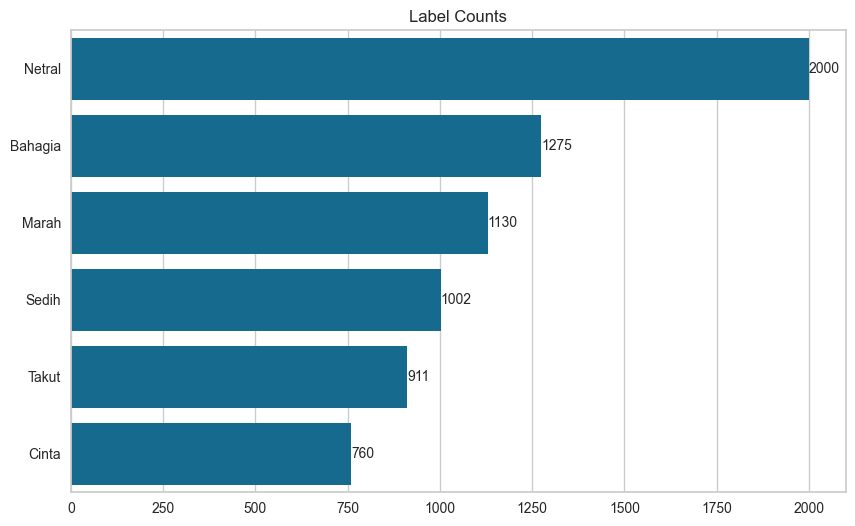

In [49]:
# Label Distribution
label_distribution = df["Label"].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.title("Label Counts")
sns.barplot(
    x=label_distribution.values,
    y=label_distribution.index,
    ax=ax
)
ax.set_ylabel("")
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

## **Checking Word Count**

------

<Figure size 2000x2000 with 0 Axes>

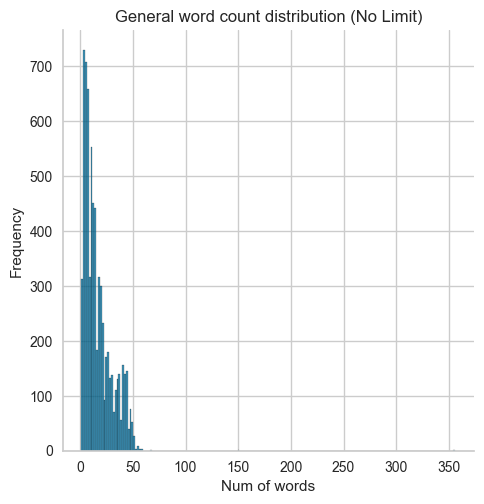

<Figure size 2000x2000 with 0 Axes>

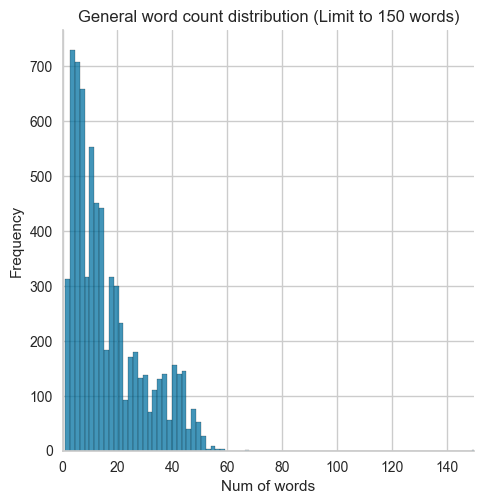

In [50]:
# Word count
df["word_count"] = df["Tweet"].apply(lambda x:len(x.split()))
plt.figure(figsize=(20,20))
sns.displot(df['word_count'])
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.title("General word count distribution (No Limit)")
plt.show()

plt.figure(figsize=(20,20))
sns.displot(df['word_count'])
plt.xlim(0, 150)
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.title("General word count distribution (Limit to 150 words)")
plt.show()

In [51]:
# Word count per label
fig = go.Figure()
color_list = ["#FF0000", "#FFFF00", "#00FF00", "#0000FF", "#00FFFF", "#FF00FF"]
i = 0
# Adding trace
for label in df["Label"].value_counts().index:
    target_df = df.loc[df["Label"] == label, "word_count"].value_counts().sort_index()
    fig.add_trace(go.Scatter(
        x=target_df.index,
        y=target_df.values,
        name=label,
        fill="tozeroy",
        marker_color=color_list[i],
    ))    
    i += 1
    
fig.update_layout(
    title='<span style="font-size:32px; font-family:Roboto">Word counts across labels</span>'
)
fig.show()

## **Basic Descriptive Statistic**

---

In [52]:
# Descriptive statistics about word counts
df.describe()

word_count
count  7078.000000
mean     16.763634
std      13.589344
min       1.000000
25%       7.000000
50%      13.000000
75%      24.000000
max     356.000000

## **Word Cloud**

---

In [56]:
def create_word_clouds(df, label_col, target_col):
    labels = df[label_col].value_counts().index
    len_label = len(labels)
    fig, axes = plt.subplots(nrows= math.ceil(len_label/2), ncols=2, figsize=(20, 20))
    row = col = 0
    for label in labels:
        filtered_df = df[df[label_col] == label]        
        if type(filtered_df[target_col].values[0]) is str: 
            concat_text = filtered_df[target_col].str.cat(sep=" ")
        else: 
            concat_token = filtered_df[target_col].sum()
            concat_text = " ".join(concat_token)
        wc = WordCloud(max_words=100, background_color='white', max_font_size=100, colormap='plasma').generate(concat_text)
        axes[row, col].axis("off")
        axes[row, col].imshow(wc, interpolation="bilinear")
        axes[row, col].set_title(label)
        if col == 1:
            row += 1
            col = 0
        else:
            col += 1
    fig.suptitle("Word Cloud Per Label", size=18, y=1)
    plt.tight_layout()
    plt.show()

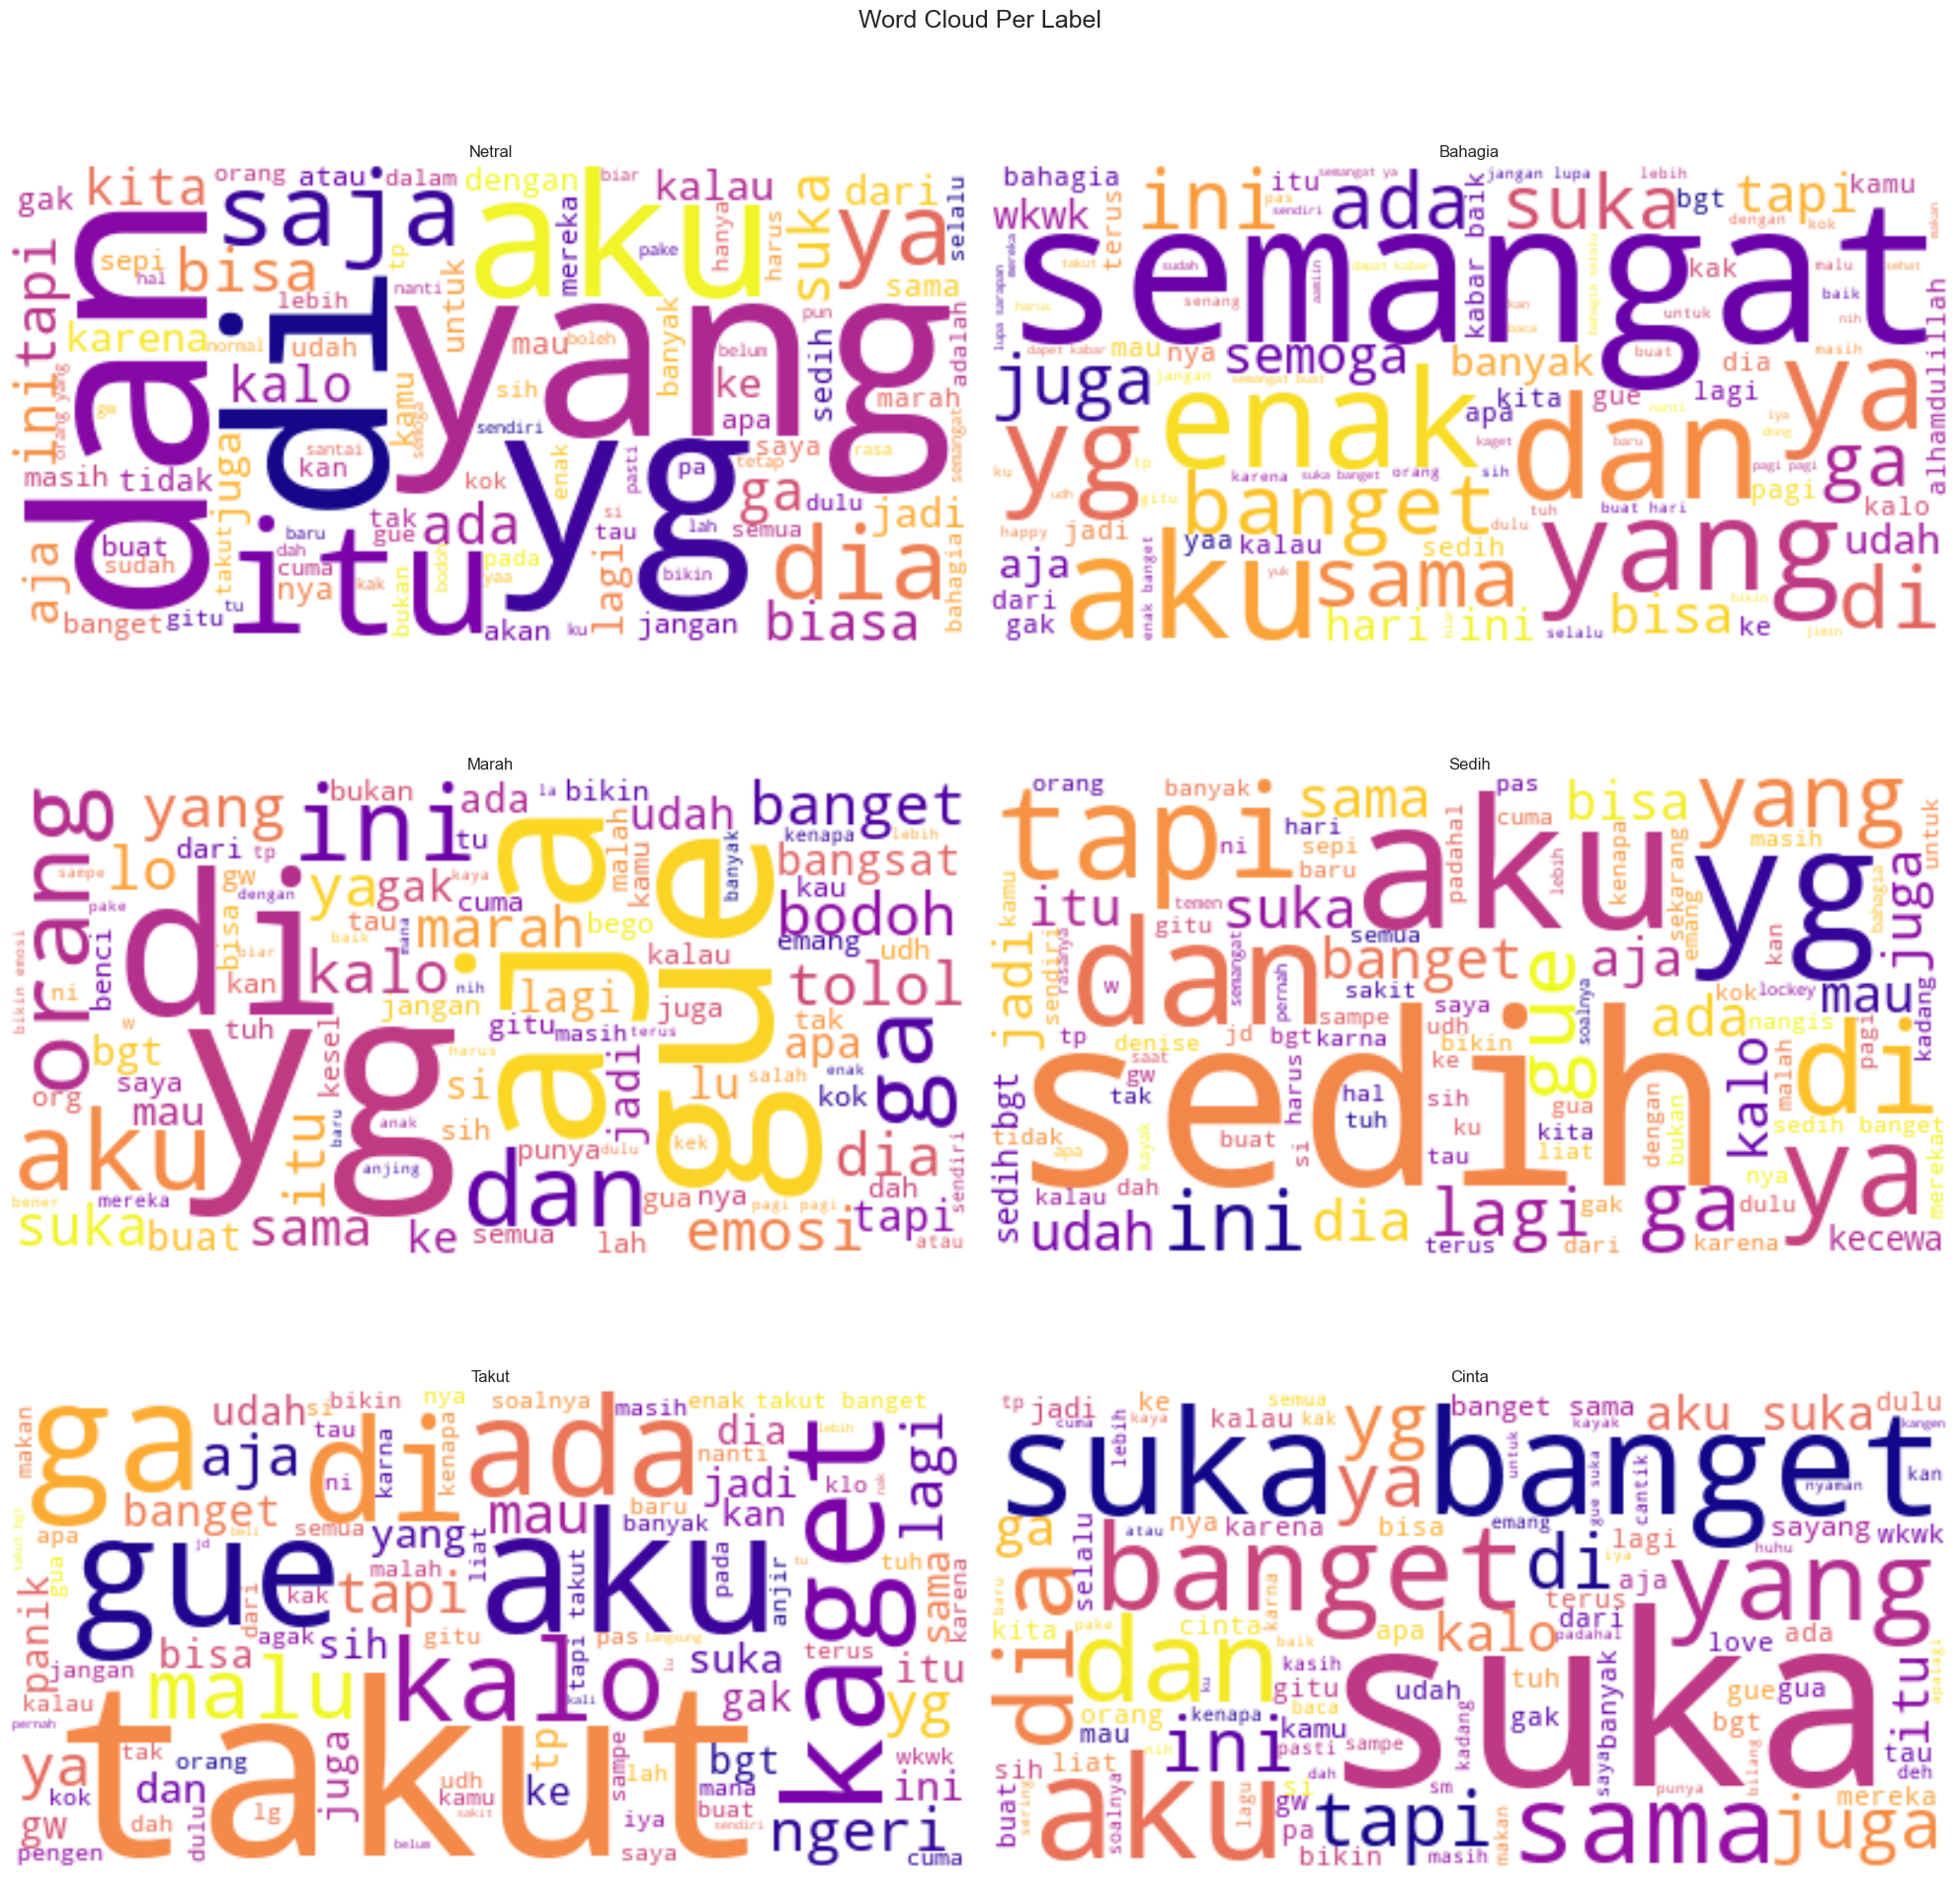

In [57]:
create_word_clouds(df, "Label", "Tweet")

## **Barplot For Word Occurence**


---

In [58]:
from collections import Counter
# Visualizing top 15 most frequent words at each label
def create_word_frequency(df, label_col, target_col):
    labels = df[label_col].value_counts().index
    len_label = len(labels)
    fig, axes = plt.subplots(nrows= int(len_label/2), ncols=2, figsize=(20, 20))
    row = col = 0
    color_palette = sns.color_palette("cividis", n_colors=15)    
    for label in labels:
        filtered_df = df[df[label_col] == label]        
        if type(filtered_df[target_col].values[0]) is str: 
            concat_token = filtered_df[target_col].str.cat(sep=" ").split()
        else: 
            concat_token = filtered_df[target_col].sum() 
        counter = Counter(concat_token)
        df_count = pd.DataFrame(
            {
                "Word": list(counter.keys()),
                "Frequency": list(counter.values())
            }
        )
        df_count = df_count.sort_values(by="Frequency", ascending=False).head(15)
        sns.barplot(
            y="Word", 
            x="Frequency", 
            data=df_count, 
            hue="Word",
            palette=color_palette, 
            ax=axes[row,col])
        axes[row, col].set_title(label)
        axes[row, col].set_ylabel('')
        axes[row, col].set_xlabel('')
        if col == 1:
            axes[row, col].invert_xaxis()
            axes[row, col].yaxis.set_label_position("right")
            axes[row, col].yaxis.tick_right()
            row += 1
            col = 0
        else:
            col += 1
    fig.suptitle("Word Frequency Per Label", size=18, y=1)
    plt.tight_layout()
    plt.show()

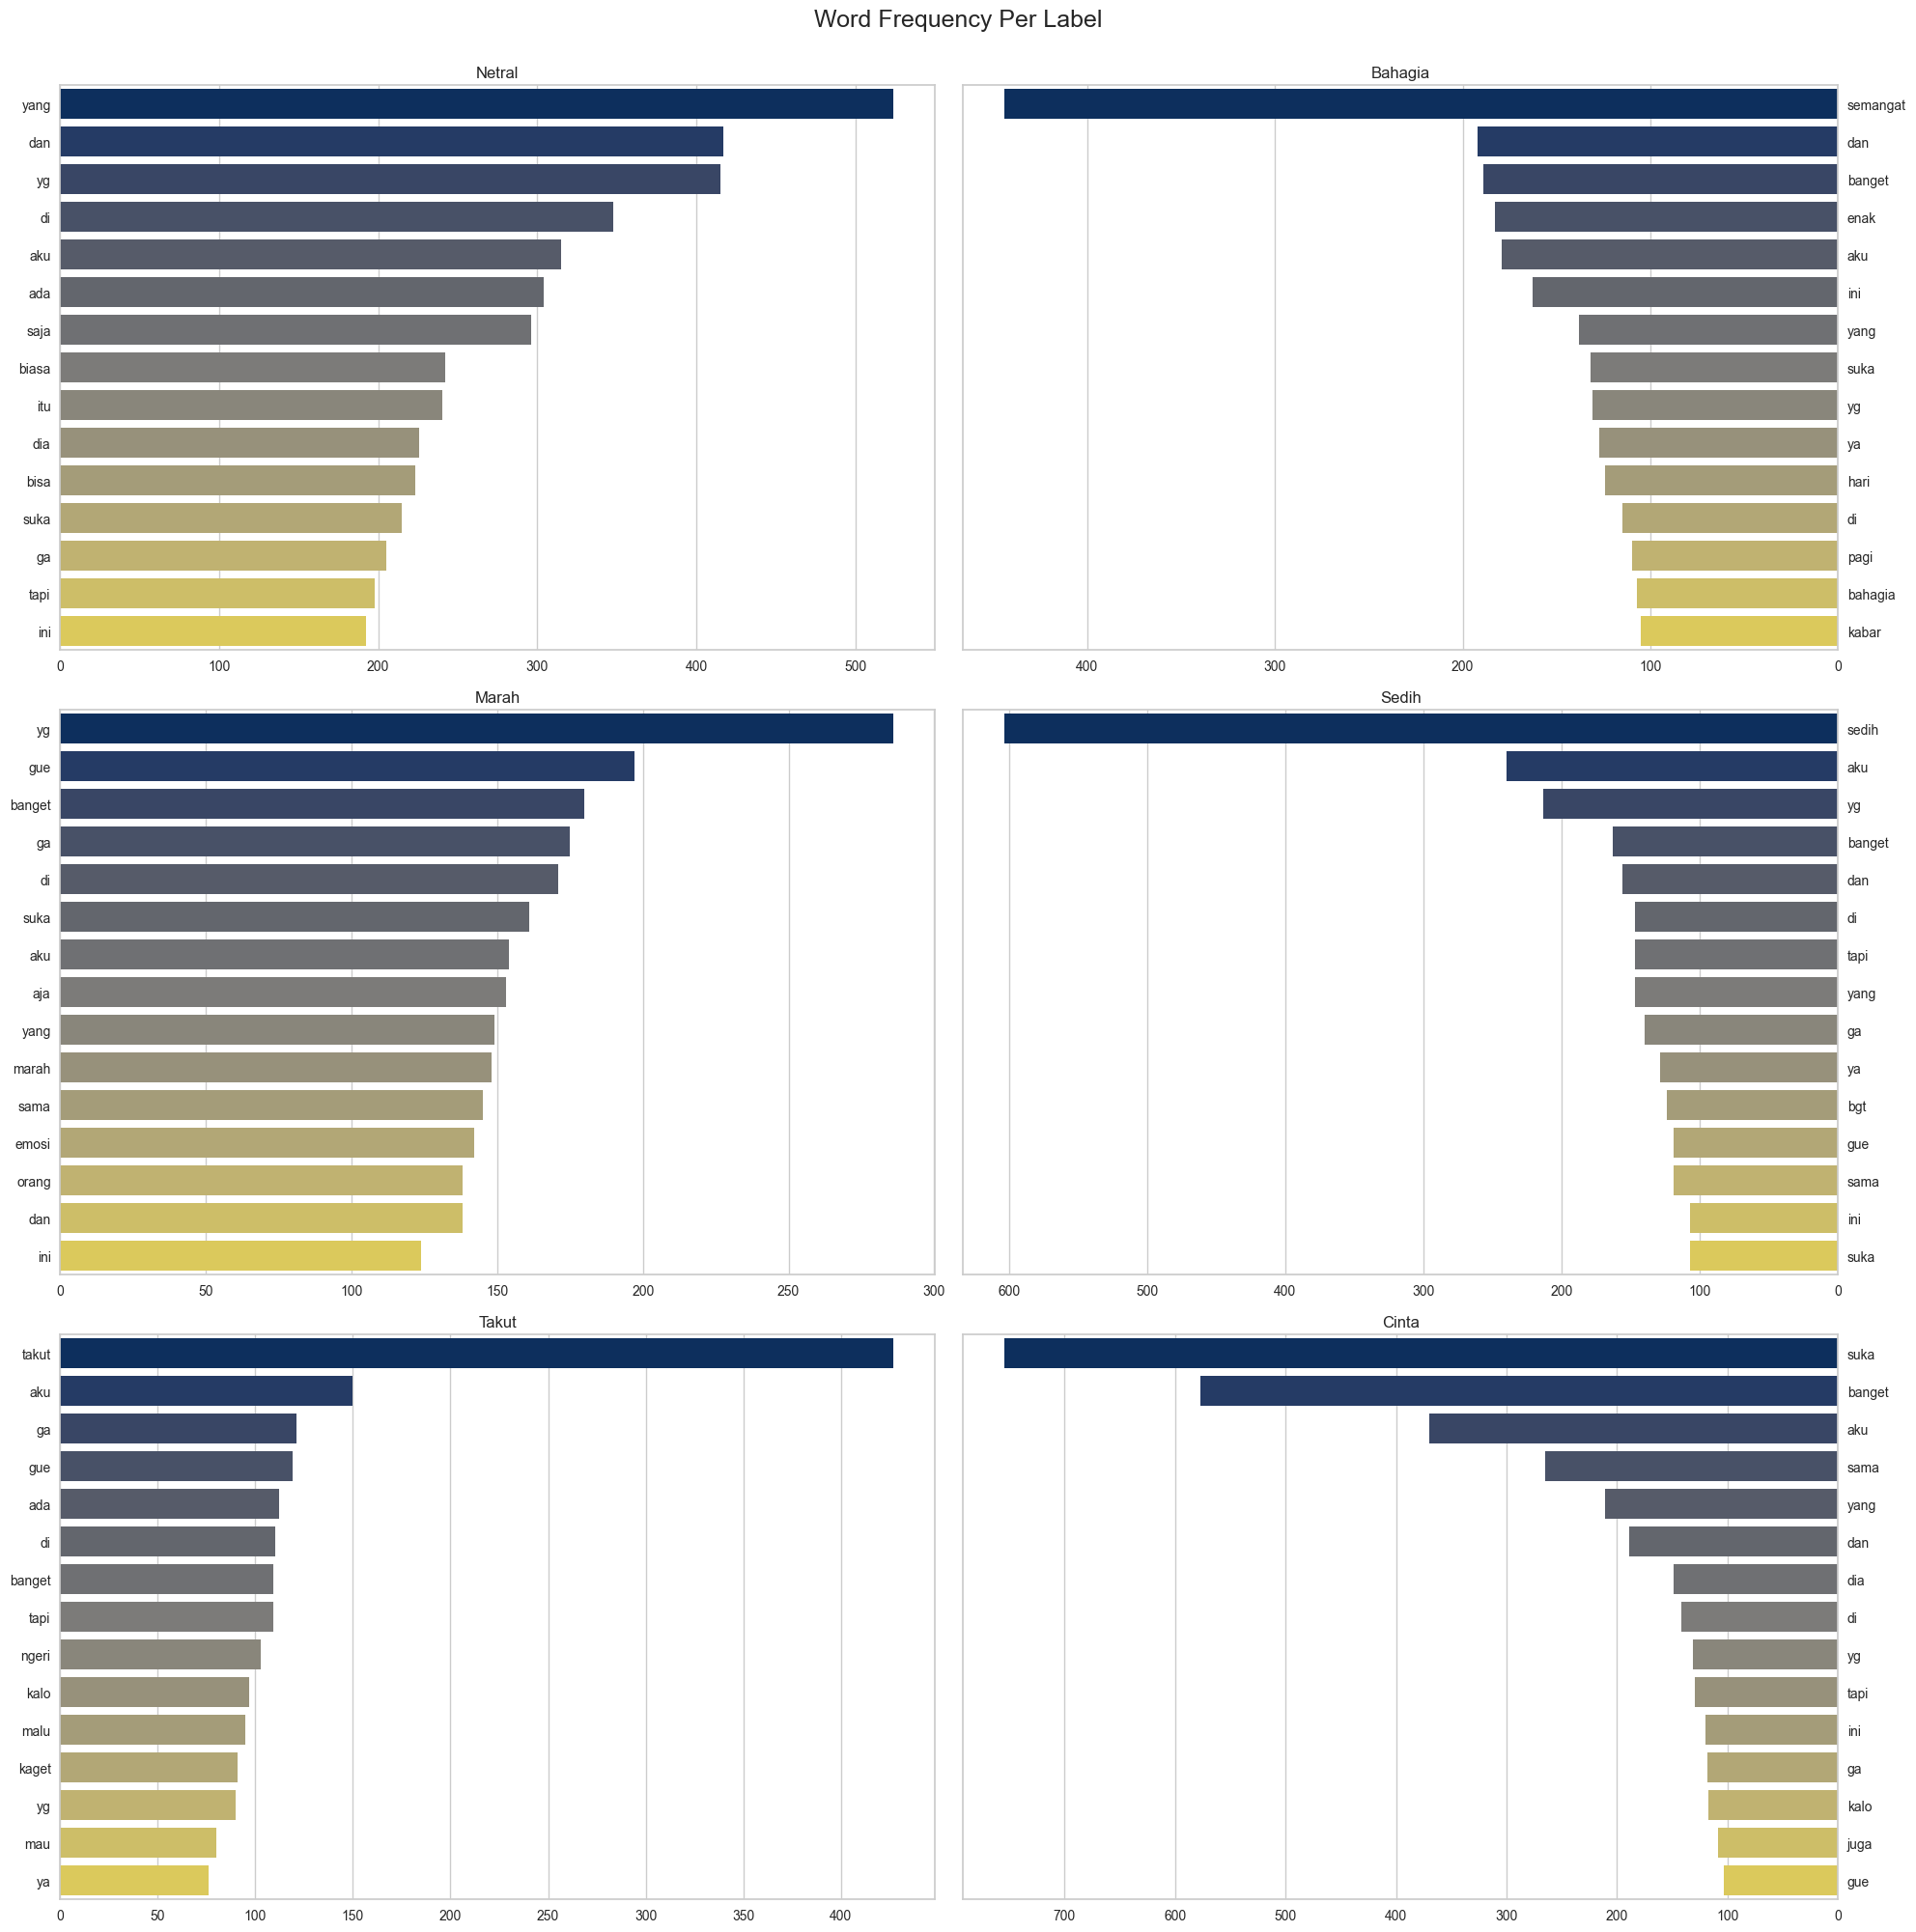

In [59]:
create_word_frequency(df, "Label", "Tweet")

## **Count Unique Token/Word**

---

In [60]:
# Function for creating a dataframe that count unique token at each specified column
def count_unique_tokens(df, column_list):
    token_count = []
    for col in column_list:
        if type(df[col].values[0]) is str:
            concat = df[col].str.cat(sep=" ").split()
        else:
            concat = list(chain.from_iterable(df[col]))
        len_concat = len(set(concat))
        token_count.append(len_concat)
    data = {"Column": column_list, " Unique Token Count": token_count} 
    return pd.DataFrame(data)

In [61]:
count_unique_tokens(df, ["Tweet"])

Column   Unique Token Count
0  Tweet                23995

# 4) Preprocessing

## **Removing duplicates**

---

In [62]:
# Dropping null values
print("Before: {}".format(df.duplicated(subset="Tweet").sum()))
df.drop_duplicates(subset="Tweet", inplace=True)
print("After: {}".format(df.duplicated(subset="Tweet").sum()))

Before: 62
After: 0


In [63]:
# Checking label distribution after removing duplicates
df["Label"].value_counts()

Label
Netral     1989
Bahagia    1255
Marah      1119
Sedih       994
Takut       905
Cinta       754
Name: count, dtype: int64

## **Basic Text Cleaning**

Procedure: 
- Removing mentions (@mention)
- Removing RE patterns ([RE text])
- Removing Reserved Keywords From Twitter (RT, etc.)
- Removing HTML Escape Codes
- Removing links
- Removing number & symbols (including emoticon)
- Removing extra spaces
- Applying lowercase

---

In [37]:
# Config
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.RESERVED)
# Function
def clean_text(text):
    pattern_re = r"\[RE (.*?)\]"
    pattern_mention = r"@[^\s]+"
    pattern_hashtag = r"#[^\s]+"
    pattern_symbols = r'[^A-Za-z\s]'
    pattern_html_code = r"&[a-zA-Z0-9]+;"
    
    # Removing mentions
    text = re.sub(pattern_mention, "", text)
    # Removing hashtags
    text = re.sub(pattern_hashtag, "", text)    
    # Removing html escape codes
    text = re.sub(pattern_html_code, "", text) 
    # Removing RE pattern at the end of tweet
    text = re.sub(pattern_re, "", text)
    # Removing links, emoji, smiley, reserved words
    text = p.clean(text)
    # Removing symbols & numbers
    text = re.sub(pattern_symbols, " ", text)
    # Performing additional cleaning (just in case)
    text = p.clean(text)
    # Lowercasing
    text = text.lower()
    return text

In [38]:
df["text_clean"] = df["Tweet"].apply(lambda x: clean_text(x))
df.tail(2)

Tweet  \
7076  gue pernah datang lebih awal, sebelum waktu nya malah terus malah dibilang kek gini (kurang lebih) saking jombolnya jadi punya banyak waktu luang ya? gue ga tau mesti seneng atau sedih -_- jengkel ahhh   
7077                                                                                                        telat lu ngasih tau faktanya min,kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

      Label  word_count  \
7076  Anger          34   
7077  Anger          18   

                                                                                                                                                                                             text_clean  
7076  gue pernah datang lebih awal sebelum waktu nya malah terus malah dibilang kek gini kurang lebih saking jombolnya jadi punya banyak waktu luang ya gue ga tau mesti seneng atau sedih jengkel ahhh  
7077                                                                                                telat lu ngasih tau faktanya min kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini

## **Tokenization**

---

In [40]:
df["text_tokenized"] = df["text_clean"].apply(lambda x: x.split())

In [41]:
df.tail(2)

Tweet  \
7076  gue pernah datang lebih awal, sebelum waktu nya malah terus malah dibilang kek gini (kurang lebih) saking jombolnya jadi punya banyak waktu luang ya? gue ga tau mesti seneng atau sedih -_- jengkel ahhh   
7077                                                                                                        telat lu ngasih tau faktanya min,kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

      Label  word_count  \
7076  Anger          34   
7077  Anger          18   

                                                                                                                                                                                             text_clean  \
7076  gue pernah datang lebih awal sebelum waktu nya malah terus malah dibilang kek gini kurang lebih saking jombolnya jadi punya banyak waktu luang ya gue ga tau mesti seneng atau sedih jengkel ahhh   
7077                                                                                                telat lu ngasih tau faktanya min kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

                                                                                                                                                                                                                           text_tokenized  
7076  [gue, pernah, datang, lebih, awal, sebelum, waktu, nya, malah, terus, malah, dibilang, kek, gini, kurang, lebih, saking, jombolnya, jadi, punya, banyak, waktu, luang, ya, gue, ga, tau, mesti, seneng, atau, sedih, jengkel, ahhh]  
7077                                                                                                              [telat, lu, ngasih, tau, faktanya, min, kalo, sblm, pertandingan, kasih, tau, fakta, nya, kan, gw, gk, se, kecewa, ini]

## **Handling Slang (Alay) Words**

Ref: https://github.com/nasalsabila/kamus-alay

---

In [42]:
# Loading the indonesian slang word dictionary
kamus_alay = pd.read_csv('/kaggle/input/kamus-alay/colloquial-indonesian-lexicon.csv')
kamus_alay.head()

slang    formal  In-dictionary  \
0     woww       wow              1   
1    aminn      amin              1   
2      met   selamat              1   
3   netaas   menetas              1   
4  keberpa  keberapa              0   

                                                                                                                                                      context  \
0                                                                                                                                                         wow   
1  Selamat ulang tahun kakak tulus semoga panjang umur kakak,sehat selalu juga,murah rezeki ya kakak dan jangan sombong kalo sukses di karirnya aminn @tulusm   
2                                                                                                         Met hari netaas kak!? Wish you all the best @tulusm   
3                                                                                                         Met hari netaas kak!? Wish you all the best @tulusm   
4                                                                                                                                    Birthday yg keberpa kak?   

   category1 category2 category3  
0   elongasi         0         0  
1   elongasi         0         0  
2  abreviasi         0         0  
3   afiksasi  elongasi         0  
4  abreviasi         0         0

In [43]:
# Getting rid of duplicated slangs.
print("Before: ", kamus_alay.duplicated(subset="slang").sum())
kamus_alay.drop_duplicates(subset="slang", inplace=True)
print("After: ", kamus_alay.duplicated(subset="slang").sum())

Before:  10675
After:  0


In [44]:
# Checking null values
kamus_alay.isna().sum()

slang            0
formal           0
In-dictionary    0
context          0
category1        0
category2        0
category3        0
dtype: int64

In [45]:
# Creating a dictionary for easier look-up
dict_alay = dict(zip(kamus_alay["slang"], kamus_alay["formal"]))

In [46]:
# Slang handling function
def slang_handling(tokens):
    cleaned_token = [dict_alay[token] if token in dict_alay else token for token in tokens]
    return cleaned_token

In [48]:
df["text_cleaned_slang"] = df["text_tokenized"].apply(lambda x: slang_handling(x))
df.tail(2)

Tweet  \
7076  gue pernah datang lebih awal, sebelum waktu nya malah terus malah dibilang kek gini (kurang lebih) saking jombolnya jadi punya banyak waktu luang ya? gue ga tau mesti seneng atau sedih -_- jengkel ahhh   
7077                                                                                                        telat lu ngasih tau faktanya min,kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

      Label  word_count  \
7076  Anger          34   
7077  Anger          18   

                                                                                                                                                                                             text_clean  \
7076  gue pernah datang lebih awal sebelum waktu nya malah terus malah dibilang kek gini kurang lebih saking jombolnya jadi punya banyak waktu luang ya gue ga tau mesti seneng atau sedih jengkel ahhh   
7077                                                                                                telat lu ngasih tau faktanya min kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

                                                                                                                                                                                                                           text_tokenized  \
7076  [gue, pernah, datang, lebih, awal, sebelum, waktu, nya, malah, terus, malah, dibilang, kek, gini, kurang, lebih, saking, jombolnya, jadi, punya, banyak, waktu, luang, ya, gue, ga, tau, mesti, seneng, atau, sedih, jengkel, ahhh]   
7077                                                                                                              [telat, lu, ngasih, tau, faktanya, min, kalo, sblm, pertandingan, kasih, tau, fakta, nya, kan, gw, gk, se, kecewa, ini]   

                                                                                                                                                                                                                             text_cleaned_slang  
7076  [gue, pernah, datang, lebih, awal, sebelum, waktu, nya, malah, terus, malah, dibilang, kayak, begini, kurang, lebih, saking, jombolnya, jadi, punya, banyak, waktu, luang, ya, gue, enggak, tau, mesti, senang, atau, sedih, jengkel, ah]  
7077                                                                                                          [telat, lu, mengasih, tau, faktanya, min, kalo, sebelum, pertandingan, kasih, tau, fakta, nya, kan, gue, enggak, se, kecewa, ini]

## **Stop-word Removal**

---

Note: 

Regarding the use of corpus simplification techniques (stop-word removal & stemming/lemmatization) on word embedding technique: 

1. Don't use standard preprocessing steps like stemming or stopword removal when you have pre-trained embeddings Some of you might used standard preprocessing steps when doing word count based feature extraction (e.g. TFIDF) such as removing stopwords, stemming etc. The reason is simple: You loose valuable information, which would help your NN to figure things out.

2. Get your vocabulary as close to the embeddings as possible I will focus in this notebook, how to achieve that. For an example I take the GoogleNews pretrained embeddings, there is no deeper reason for this choice.

Ref: https://www.kaggle.com/code/christofhenkel/how-to-preprocessing-when-using-embeddings/notebook

In [51]:
# Loading stop-word id
df_stop_word = pd.read_csv("/kaggle/input/indonesian-stoplist/stopwordbahasa.csv", names=["stopword"])
stop_word = df_stop_word["stopword"].tolist()
stop_word[:10]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir']

In [49]:
# Loading stop-word en
df_stop_word_en = pd.read_csv("/kaggle/input/stopwords/stopwords.txt", names=["stopword"])
stop_word_en = df_stop_word_en["stopword"].tolist()
stop_word_en[:10]

['x',
 'y',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'you',
 'yond',
 'yonder',
 'yon']

In [52]:
def stop_word_removal(tokens):
    cleaned_token = [token for token in tokens if token not in stop_word]
    return cleaned_token

In [53]:
def stop_word_removal_en(tokens):
    cleaned_token = [token for token in tokens if token not in stop_word_en]
    return cleaned_token

In [54]:
df["text_cleaned_stopword"] = df["text_cleaned_slang"].apply(lambda x: stop_word_removal(x))
df["text_cleaned_stopword"] = df["text_cleaned_stopword"].apply(lambda x: stop_word_removal_en(x))
df.tail(2)

Tweet  \
7076  gue pernah datang lebih awal, sebelum waktu nya malah terus malah dibilang kek gini (kurang lebih) saking jombolnya jadi punya banyak waktu luang ya? gue ga tau mesti seneng atau sedih -_- jengkel ahhh   
7077                                                                                                        telat lu ngasih tau faktanya min,kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

      Label  word_count  \
7076  Anger          34   
7077  Anger          18   

                                                                                                                                                                                             text_clean  \
7076  gue pernah datang lebih awal sebelum waktu nya malah terus malah dibilang kek gini kurang lebih saking jombolnya jadi punya banyak waktu luang ya gue ga tau mesti seneng atau sedih jengkel ahhh   
7077                                                                                                telat lu ngasih tau faktanya min kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

                                                                                                                                                                                                                           text_tokenized  \
7076  [gue, pernah, datang, lebih, awal, sebelum, waktu, nya, malah, terus, malah, dibilang, kek, gini, kurang, lebih, saking, jombolnya, jadi, punya, banyak, waktu, luang, ya, gue, ga, tau, mesti, seneng, atau, sedih, jengkel, ahhh]   
7077                                                                                                              [telat, lu, ngasih, tau, faktanya, min, kalo, sblm, pertandingan, kasih, tau, fakta, nya, kan, gw, gk, se, kecewa, ini]   

                                                                                                                                                                                                                             text_cleaned_slang  \
7076  [gue, pernah, datang, lebih, awal, sebelum, waktu, nya, malah, terus, malah, dibilang, kayak, begini, kurang, lebih, saking, jombolnya, jadi, punya, banyak, waktu, luang, ya, gue, enggak, tau, mesti, senang, atau, sedih, jengkel, ah]   
7077                                                                                                          [telat, lu, mengasih, tau, faktanya, min, kalo, sebelum, pertandingan, kasih, tau, fakta, nya, kan, gue, enggak, se, kecewa, ini]   

                                                                                       text_cleaned_stopword  
7076  [gue, nya, dibilang, kayak, saking, jombolnya, luang, ya, gue, tau, mesti, senang, sedih, jengkel, ah]  
7077      [telat, lu, mengasih, tau, faktanya, min, kalo, pertandingan, kasih, tau, fakta, nya, gue, kecewa]

## **Lemmatization**

Ref: 
- https://github.com/kumparan/nlp-id

---

In [55]:
from nlp_id.lemmatizer import Lemmatizer 
lemmatizer = Lemmatizer() 
def lemmatizer_nlp_id(tokens):
    text = " ".join(tokens)
    text_lemmatize = lemmatizer.lemmatize(text)
    return text_lemmatize.split()

In [56]:
df["text_lemmatized_nlp-id"] = df["text_cleaned_stopword"].apply(lambda x: lemmatizer_nlp_id(x))
df.tail(2)

Tweet  \
7076  gue pernah datang lebih awal, sebelum waktu nya malah terus malah dibilang kek gini (kurang lebih) saking jombolnya jadi punya banyak waktu luang ya? gue ga tau mesti seneng atau sedih -_- jengkel ahhh   
7077                                                                                                        telat lu ngasih tau faktanya min,kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

      Label  word_count  \
7076  Anger          34   
7077  Anger          18   

                                                                                                                                                                                             text_clean  \
7076  gue pernah datang lebih awal sebelum waktu nya malah terus malah dibilang kek gini kurang lebih saking jombolnya jadi punya banyak waktu luang ya gue ga tau mesti seneng atau sedih jengkel ahhh   
7077                                                                                                telat lu ngasih tau faktanya min kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

                                                                                                                                                                                                                           text_tokenized  \
7076  [gue, pernah, datang, lebih, awal, sebelum, waktu, nya, malah, terus, malah, dibilang, kek, gini, kurang, lebih, saking, jombolnya, jadi, punya, banyak, waktu, luang, ya, gue, ga, tau, mesti, seneng, atau, sedih, jengkel, ahhh]   
7077                                                                                                              [telat, lu, ngasih, tau, faktanya, min, kalo, sblm, pertandingan, kasih, tau, fakta, nya, kan, gw, gk, se, kecewa, ini]   

                                                                                                                                                                                                                             text_cleaned_slang  \
7076  [gue, pernah, datang, lebih, awal, sebelum, waktu, nya, malah, terus, malah, dibilang, kayak, begini, kurang, lebih, saking, jombolnya, jadi, punya, banyak, waktu, luang, ya, gue, enggak, tau, mesti, senang, atau, sedih, jengkel, ah]   
7077                                                                                                          [telat, lu, mengasih, tau, faktanya, min, kalo, sebelum, pertandingan, kasih, tau, fakta, nya, kan, gue, enggak, se, kecewa, ini]   

                                                                                       text_cleaned_stopword  \
7076  [gue, nya, dibilang, kayak, saking, jombolnya, luang, ya, gue, tau, mesti, senang, sedih, jengkel, ah]   
7077      [telat, lu, mengasih, tau, faktanya, min, kalo, pertandingan, kasih, tau, fakta, nya, gue, kecewa]   

                                                                                    text_lemmatized_nlp-id  
7076  [gue, nya, bilang, kayak, saking, jombolnya, luang, ya, gue, tau, mesti, senang, sedih, jengkel, ah]  
7077               [telat, lu, kasih, tau, fakta, min, kalo, tanding, kasih, tau, fakta, nya, gue, kecewa]

**Extra Cleaning After Lemmatization (Stopword)**

---

In [58]:
df["final_clean"] = df["text_lemmatized_nlp-id"].apply(lambda x: stop_word_removal(x))
df["final_clean"] = df["final_clean"].apply(lambda x: stop_word_removal_en(x))
df.tail(2)

Tweet  \
7076  gue pernah datang lebih awal, sebelum waktu nya malah terus malah dibilang kek gini (kurang lebih) saking jombolnya jadi punya banyak waktu luang ya? gue ga tau mesti seneng atau sedih -_- jengkel ahhh   
7077                                                                                                        telat lu ngasih tau faktanya min,kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

      Label  word_count  \
7076  Anger          34   
7077  Anger          18   

                                                                                                                                                                                             text_clean  \
7076  gue pernah datang lebih awal sebelum waktu nya malah terus malah dibilang kek gini kurang lebih saking jombolnya jadi punya banyak waktu luang ya gue ga tau mesti seneng atau sedih jengkel ahhh   
7077                                                                                                telat lu ngasih tau faktanya min kalo sblm pertandingan kasih tau fakta nya kan gw gk se kecewa ini   

                                                                                                                                                                                                                           text_tokenized  \
7076  [gue, pernah, datang, lebih, awal, sebelum, waktu, nya, malah, terus, malah, dibilang, kek, gini, kurang, lebih, saking, jombolnya, jadi, punya, banyak, waktu, luang, ya, gue, ga, tau, mesti, seneng, atau, sedih, jengkel, ahhh]   
7077                                                                                                              [telat, lu, ngasih, tau, faktanya, min, kalo, sblm, pertandingan, kasih, tau, fakta, nya, kan, gw, gk, se, kecewa, ini]   

                                                                                                                                                                                                                             text_cleaned_slang  \
7076  [gue, pernah, datang, lebih, awal, sebelum, waktu, nya, malah, terus, malah, dibilang, kayak, begini, kurang, lebih, saking, jombolnya, jadi, punya, banyak, waktu, luang, ya, gue, enggak, tau, mesti, senang, atau, sedih, jengkel, ah]   
7077                                                                                                          [telat, lu, mengasih, tau, faktanya, min, kalo, sebelum, pertandingan, kasih, tau, fakta, nya, kan, gue, enggak, se, kecewa, ini]   

                                                                                       text_cleaned_stopword  \
7076  [gue, nya, dibilang, kayak, saking, jombolnya, luang, ya, gue, tau, mesti, senang, sedih, jengkel, ah]   
7077      [telat, lu, mengasih, tau, faktanya, min, kalo, pertandingan, kasih, tau, fakta, nya, gue, kecewa]   

                                                                                    text_lemmatized_nlp-id  \
7076  [gue, nya, bilang, kayak, saking, jombolnya, luang, ya, gue, tau, mesti, senang, sedih, jengkel, ah]   
7077               [telat, lu, kasih, tau, fakta, min, kalo, tanding, kasih, tau, fakta, nya, gue, kecewa]   

                                                                                               final_clean  
7076  [gue, nya, bilang, kayak, saking, jombolnya, luang, ya, gue, tau, mesti, senang, sedih, jengkel, ah]  
7077               [telat, lu, kasih, tau, fakta, min, kalo, tanding, kasih, tau, fakta, nya, gue, kecewa]

---

In [59]:
# Final Save 
df.to_csv('final_clean_merged.csv', index=False)

## **Visualization After Preprocessing**

----

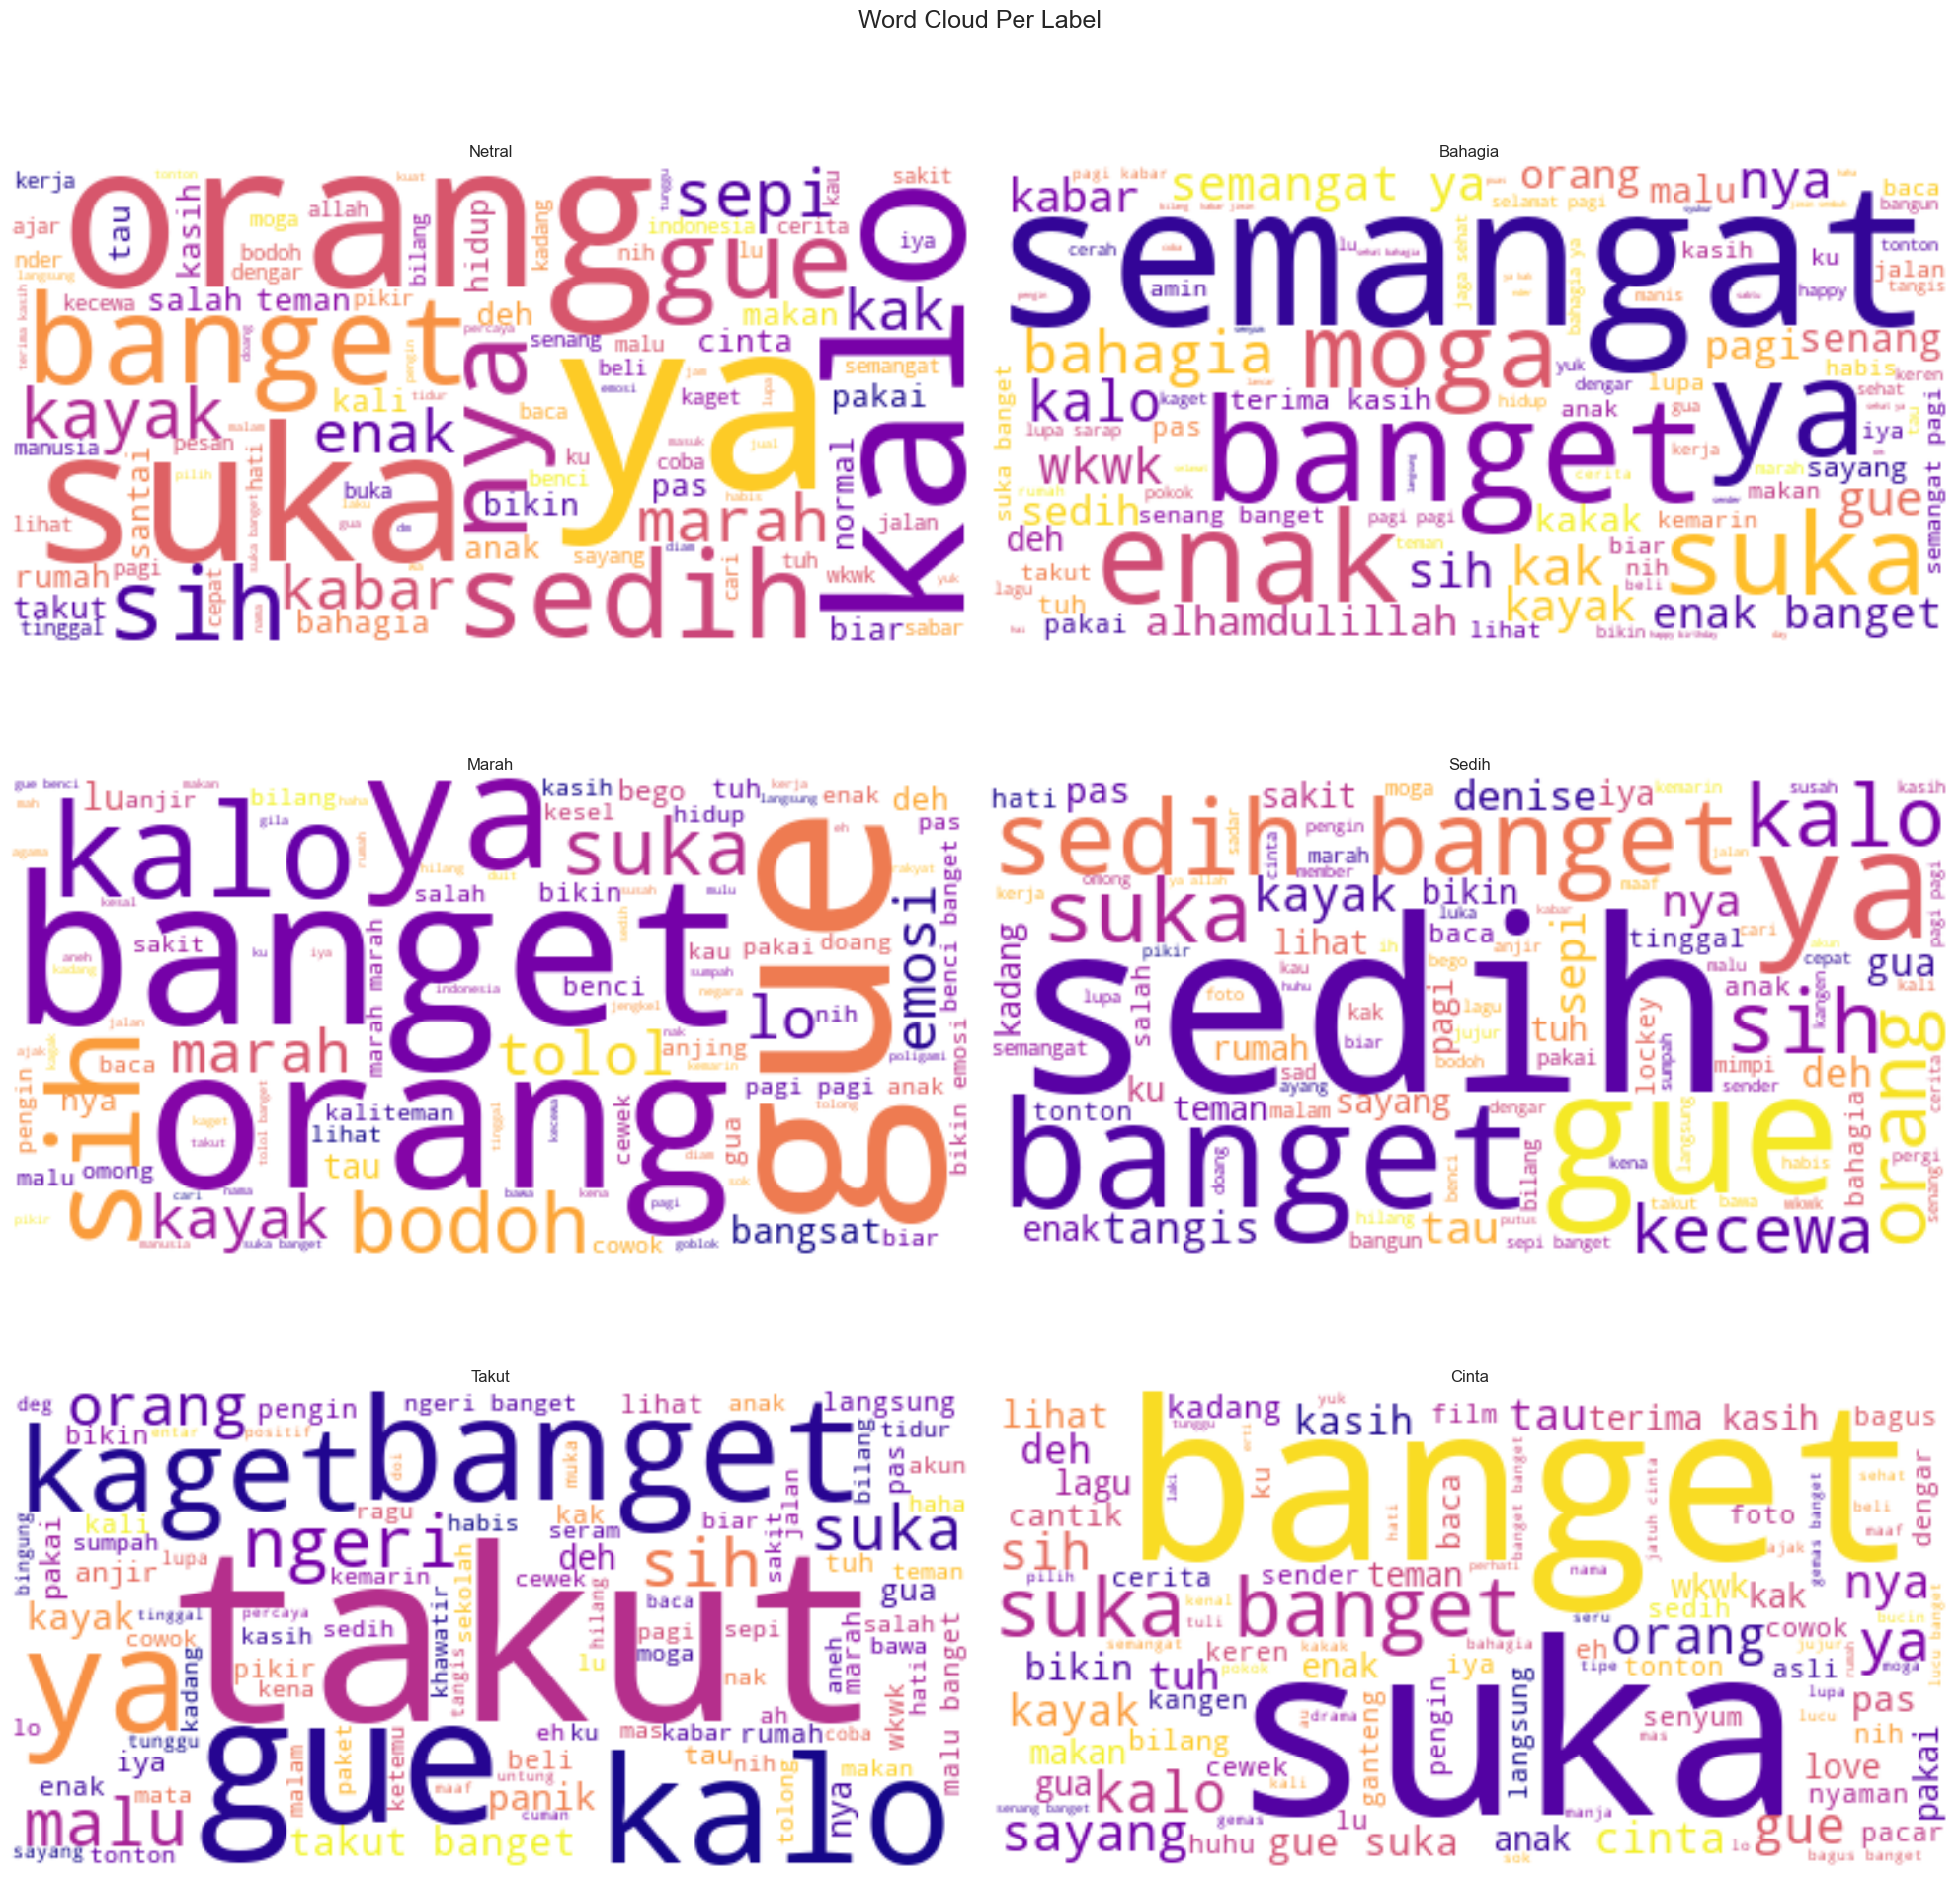

In [68]:
create_word_clouds(df, "Label", "final_clean")

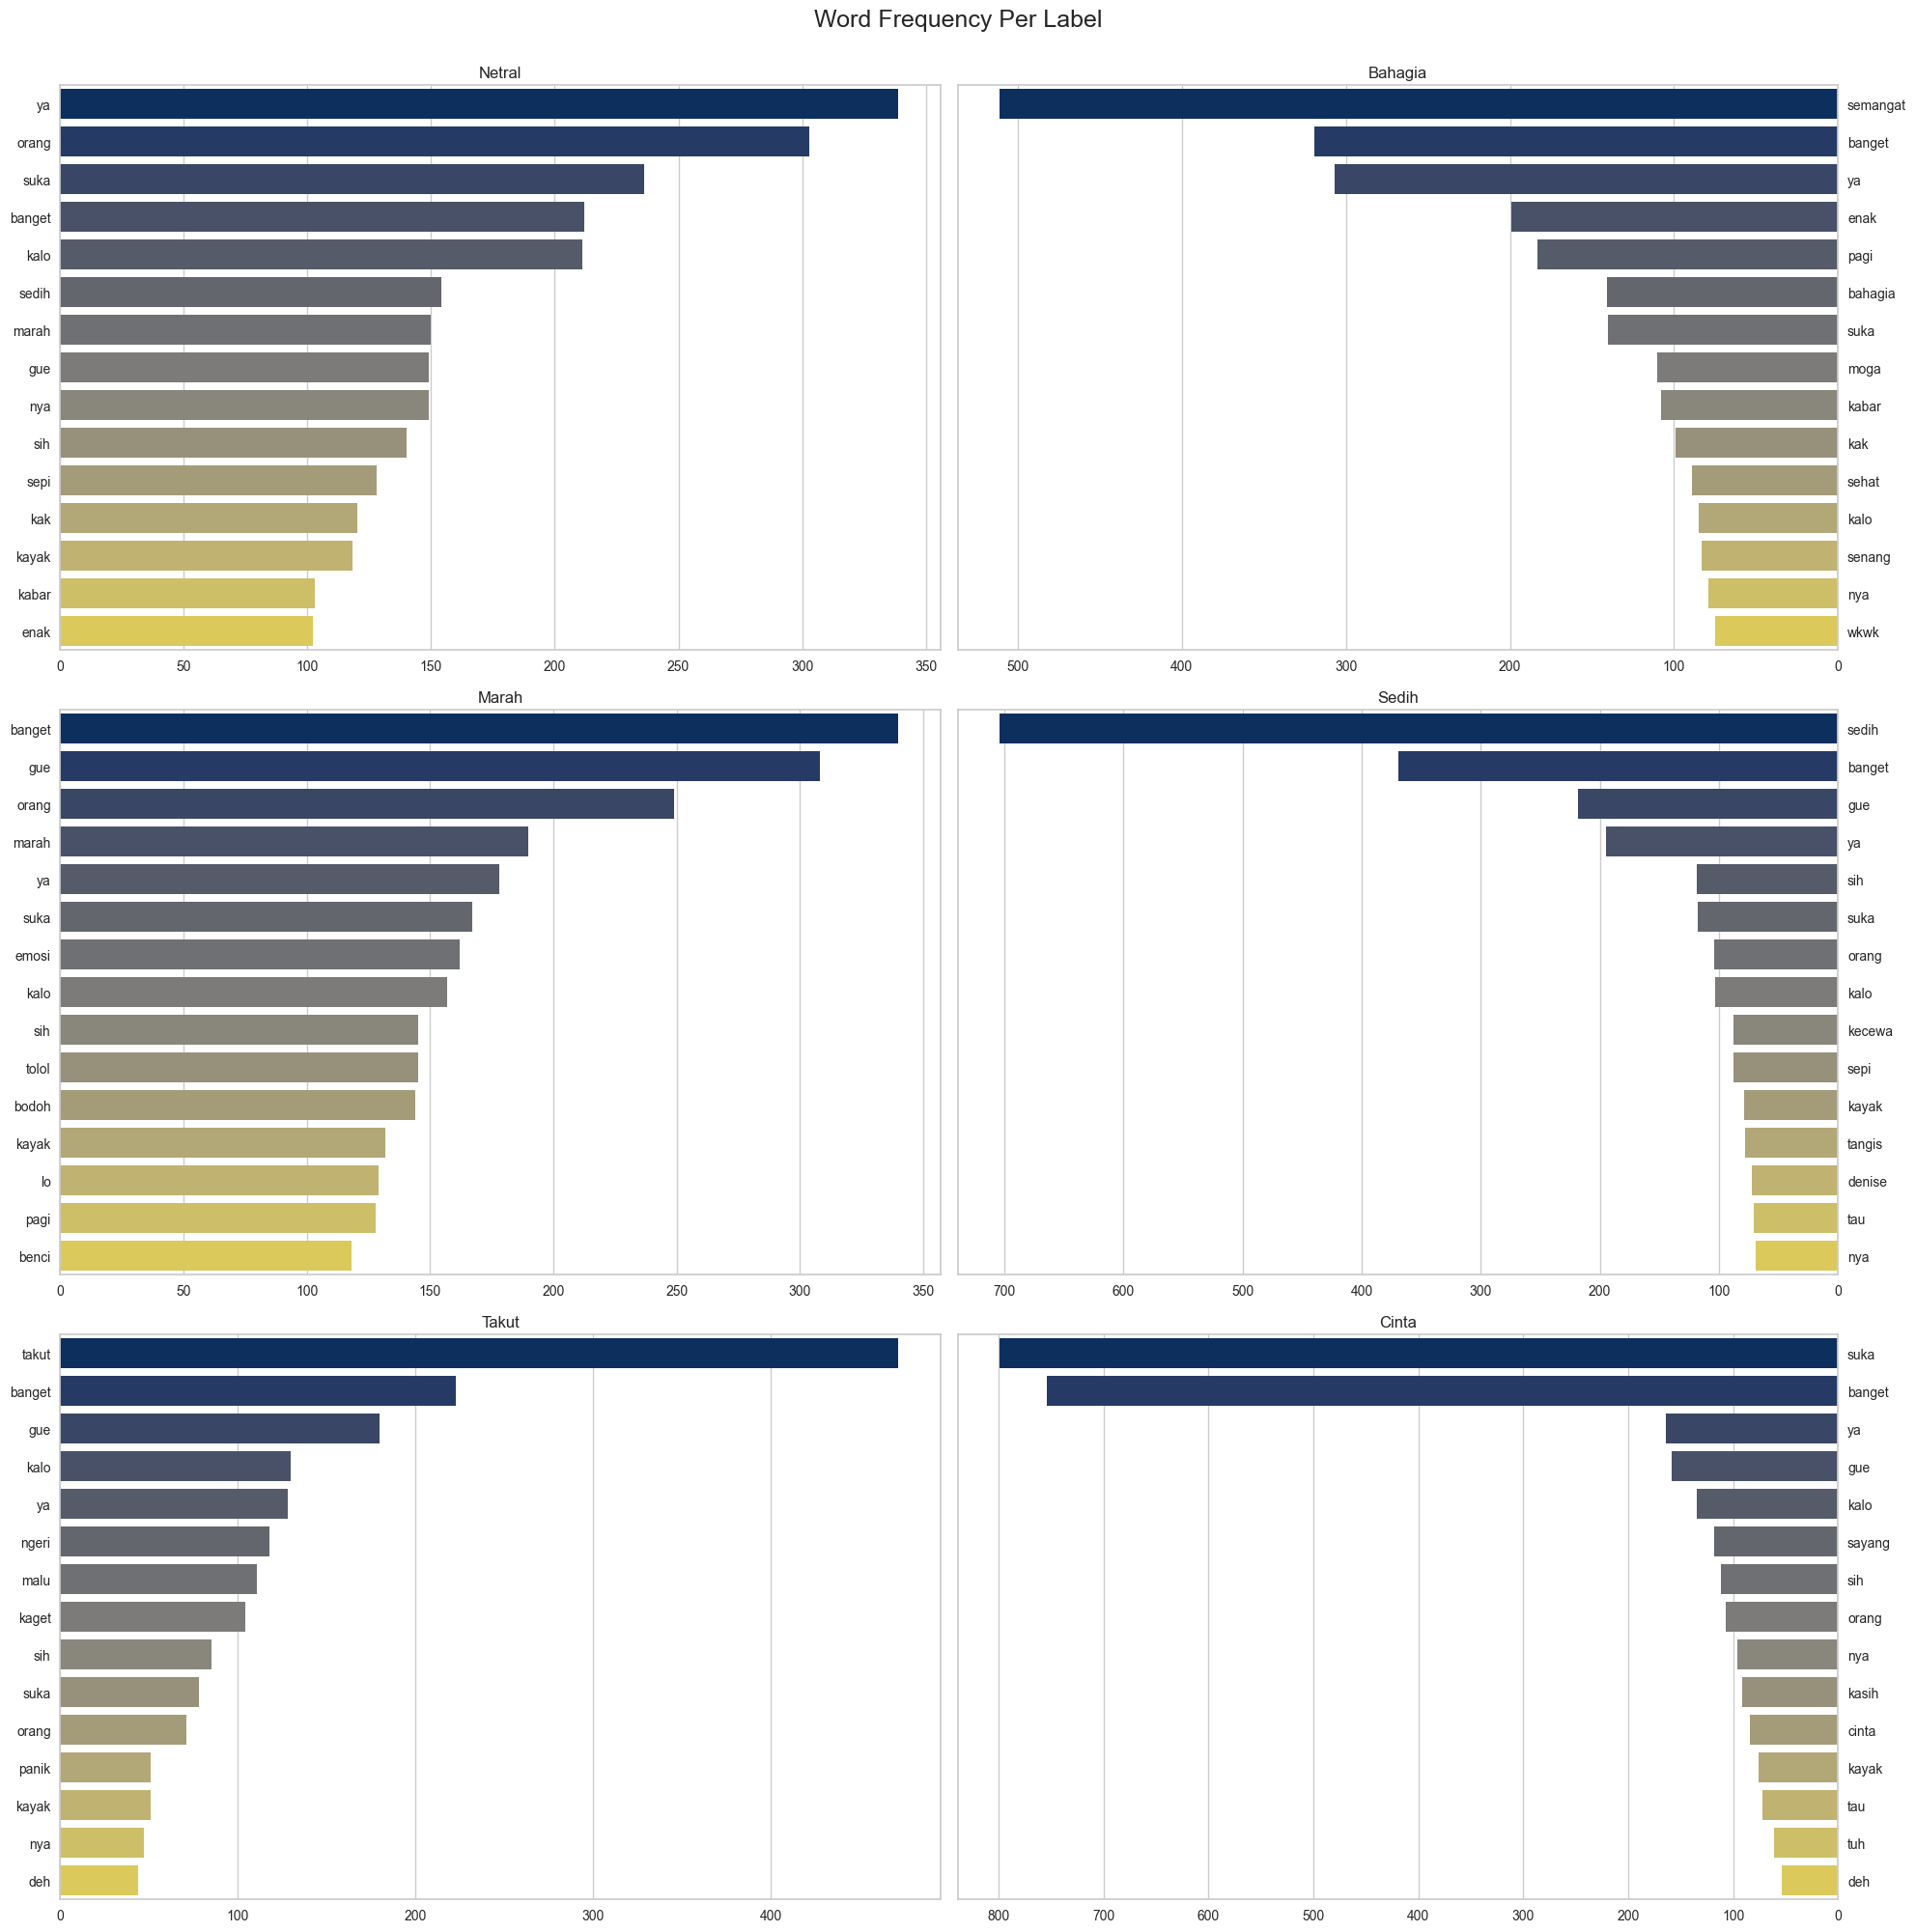

In [69]:
create_word_frequency(df, "Label", "final_clean")

In [70]:
included_col = [col for col in df.columns if col not in ["Label", "word_count"]]
count_unique_tokens(df, included_col)

Column   Unique Token Count
0                   Tweet                23995
1              text_clean                16918
2          text_tokenized                16918
3      text_cleaned_slang                15920
4   text_cleaned_stopword                15206
5  text_lemmatized_nlp-id                12119
6             final_clean                11945

## **Loading Processed Data**

---

In [15]:
df = pd.read_csv("dataset/final_clean_merged.csv")
df.head(1)

Tweet  \
0  akibat dari telat bangun, anak ikut bangun dan dapur dan rumah tidak kepegang sampe jam segini. sedih karena berantakan, tp gppa dehh penting anak dah mandi dan kenyang dulu. alon-alon asal kelakon   

  Label  word_count  \
0   Sad          32   

                                                                                                                                                                                          text_clean  \
0  akibat dari telat bangun anak ikut bangun dan dapur dan rumah tidak kepegang sampe jam segini sedih karena berantakan tp gppa dehh penting anak dah mandi dan kenyang dulu alon alon asal kelakon   

                                                                                                                                                                                                                                                                                          text_tokenized  \
0  ['akibat', 'dari', 'telat', 'bangun', 'anak', 'ikut', 'bangun', 'dan', 'dapur', 'dan', 'rumah', 'tidak', 'kepegang', 'sampe', 'jam', 'segini', 'sedih', 'karena', 'berantakan', 'tp', 'gppa', 'dehh', 'penting', 'anak', 'dah', 'mandi', 'dan', 'kenyang', 'dulu', 'alon', 'alon', 'asal', 'kelakon']   

                                                                                                                                                                                                                                                                                        text_cleaned_slang  \
0  ['akibat', 'dari', 'telat', 'bangun', 'anak', 'ikut', 'bangun', 'dan', 'dapur', 'dan', 'rumah', 'tidak', 'kepegang', 'sampai', 'jam', 'segini', 'sedih', 'karena', 'berantakan', 'tapi', 'gppa', 'deh', 'penting', 'anak', 'deh', 'mandi', 'dan', 'kenyang', 'dulu', 'alon', 'alon', 'asal', 'kelakon']   

                                                                                                                                                                                text_cleaned_stopword  \
0  ['akibat', 'telat', 'bangun', 'anak', 'bangun', 'dapur', 'rumah', 'kepegang', 'jam', 'segini', 'sedih', 'berantakan', 'gppa', 'deh', 'anak', 'deh', 'mandi', 'kenyang', 'alon', 'alon', 'kelakon']   

                                                                                                                                                                      text_lemmatized_nlp-id  \
0  ['akibat', 'telat', 'bangun', 'anak', 'bangun', 'dapur', 'rumah', 'pegang', 'jam', 'gin', 'sedih', 'berantak', 'gppa', 'deh', 'anak', 'deh', 'mandi', 'kenyang', 'alon', 'alon', 'lakon']   

                                                                                                                                                                                 final_clean  
0  ['akibat', 'telat', 'bangun', 'anak', 'bangun', 'dapur', 'rumah', 'pegang', 'jam', 'gin', 'sedih', 'berantak', 'gppa', 'deh', 'anak', 'deh', 'mandi', 'kenyang', 'alon', 'alon', 'lakon']

In [16]:
# Converting tokenized column from string to list of string
tokenized_columns = ['text_tokenized', 'text_cleaned_slang', 'text_cleaned_stopword', 'text_lemmatized_nlp-id', 'final_clean']
for col in tokenized_columns:
    df[col] = df[col].map(lambda x: ast.literal_eval(x))
df.head(1)

Tweet  \
0  akibat dari telat bangun, anak ikut bangun dan dapur dan rumah tidak kepegang sampe jam segini. sedih karena berantakan, tp gppa dehh penting anak dah mandi dan kenyang dulu. alon-alon asal kelakon   

  Label  word_count  \
0   Sad          32   

                                                                                                                                                                                          text_clean  \
0  akibat dari telat bangun anak ikut bangun dan dapur dan rumah tidak kepegang sampe jam segini sedih karena berantakan tp gppa dehh penting anak dah mandi dan kenyang dulu alon alon asal kelakon   

                                                                                                                                                                                                                        text_tokenized  \
0  [akibat, dari, telat, bangun, anak, ikut, bangun, dan, dapur, dan, rumah, tidak, kepegang, sampe, jam, segini, sedih, karena, berantakan, tp, gppa, dehh, penting, anak, dah, mandi, dan, kenyang, dulu, alon, alon, asal, kelakon]   

                                                                                                                                                                                                                      text_cleaned_slang  \
0  [akibat, dari, telat, bangun, anak, ikut, bangun, dan, dapur, dan, rumah, tidak, kepegang, sampai, jam, segini, sedih, karena, berantakan, tapi, gppa, deh, penting, anak, deh, mandi, dan, kenyang, dulu, alon, alon, asal, kelakon]   

                                                                                                                                      text_cleaned_stopword  \
0  [akibat, telat, bangun, anak, bangun, dapur, rumah, kepegang, jam, segini, sedih, berantakan, gppa, deh, anak, deh, mandi, kenyang, alon, alon, kelakon]   

                                                                                                                            text_lemmatized_nlp-id  \
0  [akibat, telat, bangun, anak, bangun, dapur, rumah, pegang, jam, gin, sedih, berantak, gppa, deh, anak, deh, mandi, kenyang, alon, alon, lakon]   

                                                                                                                                       final_clean  
0  [akibat, telat, bangun, anak, bangun, dapur, rumah, pegang, jam, gin, sedih, berantak, gppa, deh, anak, deh, mandi, kenyang, alon, alon, lakon]

In [17]:
# Label Mapping EN-ID
en_id_mapping = {
    "Neutral":"Netral",
    "Joy":"Bahagia",
    "Anger":"Marah",
    "Sad":"Sedih",
    "Fear":"Takut",
    "Love":"Cinta"
}
df["Label"] = df["Label"].map(en_id_mapping)
df["Label"].value_counts()

Label
Netral     2000
Bahagia    1275
Marah      1130
Sedih      1002
Takut       911
Cinta       760
Name: count, dtype: int64

## **Target Encoding**

---

In [18]:
le = LabelEncoder()
le.fit(df['Label'])
df["label_encoded"] = le.transform(df["Label"])
df.head(1)

Tweet  \
0  akibat dari telat bangun, anak ikut bangun dan dapur dan rumah tidak kepegang sampe jam segini. sedih karena berantakan, tp gppa dehh penting anak dah mandi dan kenyang dulu. alon-alon asal kelakon   

   Label  word_count  \
0  Sedih          32   

                                                                                                                                                                                          text_clean  \
0  akibat dari telat bangun anak ikut bangun dan dapur dan rumah tidak kepegang sampe jam segini sedih karena berantakan tp gppa dehh penting anak dah mandi dan kenyang dulu alon alon asal kelakon   

                                                                                                                                                                                                                        text_tokenized  \
0  [akibat, dari, telat, bangun, anak, ikut, bangun, dan, dapur, dan, rumah, tidak, kepegang, sampe, jam, segini, sedih, karena, berantakan, tp, gppa, dehh, penting, anak, dah, mandi, dan, kenyang, dulu, alon, alon, asal, kelakon]   

                                                                                                                                                                                                                      text_cleaned_slang  \
0  [akibat, dari, telat, bangun, anak, ikut, bangun, dan, dapur, dan, rumah, tidak, kepegang, sampai, jam, segini, sedih, karena, berantakan, tapi, gppa, deh, penting, anak, deh, mandi, dan, kenyang, dulu, alon, alon, asal, kelakon]   

                                                                                                                                      text_cleaned_stopword  \
0  [akibat, telat, bangun, anak, bangun, dapur, rumah, kepegang, jam, segini, sedih, berantakan, gppa, deh, anak, deh, mandi, kenyang, alon, alon, kelakon]   

                                                                                                                            text_lemmatized_nlp-id  \
0  [akibat, telat, bangun, anak, bangun, dapur, rumah, pegang, jam, gin, sedih, berantak, gppa, deh, anak, deh, mandi, kenyang, alon, alon, lakon]   

                                                                                                                                       final_clean  \
0  [akibat, telat, bangun, anak, bangun, dapur, rumah, pegang, jam, gin, sedih, berantak, gppa, deh, anak, deh, mandi, kenyang, alon, alon, lakon]   

   label_encoded  
0              4

In [19]:
# Encoding Mapping
label_mapping = dict(enumerate(le.classes_))
conf_matrix_label = list(label_mapping.values())
label_mapping

{0: 'Bahagia', 1: 'Cinta', 2: 'Marah', 3: 'Netral', 4: 'Sedih', 5: 'Takut'}

## **Data Split**

---

In [20]:
# Processed Data Split (For classical Model)
X = df["final_clean"].map(lambda x: " ".join(x))
y = df["label_encoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
# Raw Data Split (Dirty Data)
X_raw = df["Tweet"]
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y, test_size=0.2, stratify=y, random_state=42)

# 5) Independent Feature Extraction (Non-Pipeline)

## **Fast-Text**

Details:
- Preprocess: Basic Cleaning, Tokenization

Ref: 
- https://fasttext.cc/docs/en/support.html
- https://fasttext.cc/docs/en/crawl-vectors.html

---

In [14]:
# Loading the embedding
embedding_fast_text = gensim.models.fasttext.load_facebook_vectors('/kaggle/input/word-embedding-id-fast-text/cc.id.300.bin')
embedding_fast_text

In [15]:
# Creating a word index 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Setting vocab size & embedding dimension
vocab_size = len(word_index) + 1  # +1 for padding or unknown words
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in embedding_fast_text:
        embedding_matrix[i] = embedding_fast_text[word]
    else:
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

In [16]:
max_length = 80
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Applying tokenizer
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(
    X_train,
    maxlen=max_length, 
    truncating=trunc_type
)

X_test = pad_sequences(
    X_test,
    maxlen=max_length, 
    truncating=trunc_type
)

In [19]:
# Resampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [18]:
del embedding_fast_text

## **Tensorflow Text Preprocessing**

Details:
- Preprocess: Basic Cleaning, Tokenization, Slang Handling



---

In [72]:
vocab_size = 5000
max_length = 70
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Applying Tokenizer to training set
tokenizer =  Tokenizer(
    num_words=vocab_size,
    oov_token=oov_tok
)
tokenizer.fit_on_texts(X_train)
X_train_tf = tokenizer.texts_to_sequences(X_train)
X_test_tf = tokenizer.texts_to_sequences(X_test)

X_train_tf = pad_sequences(
    X_train_tf,
    maxlen=max_length, 
    truncating=trunc_type
)

X_test_tf = pad_sequences(
    X_test_tf,
    maxlen=max_length, 
    truncating=trunc_type
)

# 6) Modeling

## Modeling Utilities


----

In [21]:
def scikit_modeling(pipeline, objective, X_train, X_test, y_train, y_test, model_name, n_trials, labels, scoring):
    # Finding the best pipeline based on the test score
    base_pipeline, base_score = model_baseline(pipeline, X_train, X_test, y_train, y_test, labels, scoring)
    tuned_pipeline, tuned_score = model_tuned(objective, pipeline, X_train, X_test, y_train, y_test, model_name, n_trials, labels, scoring)
    best_pipeline = base_pipeline if base_score > tuned_score else tuned_pipeline
    
    # Getting y-pred & y-probabilites
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    y_probas = best_pipeline.predict_proba(X_test)
    
    # Wandb logging
    with wandb.init(project="emotion_analysis_V2", name=model_name) as run:
        X_train_transformed = best_pipeline.named_steps['tfidf'].transform(X_train)
        X_test_transformed = best_pipeline.named_steps['tfidf'].transform(X_test)    
        wandb.sklearn.plot_classifier(
            best_pipeline.named_steps["clf"],
            X_train_transformed,
            X_test_transformed,
            y_train,
            y_test,
            y_pred,
            y_probas,
            labels,
            model_name=model_name,
            feature_names=None,
            log_learning_curve=True
        )    
    
    joblib.dump(best_pipeline, "models/" + model_name + ".joblib") # Saving tuned model

In [22]:
def model_viz(pipeline, X_train, X_test, y_train, y_test, labels, scoring):
    fig, axes = plt.subplots(nrows= 1, ncols=2, figsize=(16, 8))
    # Confusion Matrix
    confusion_matrix(
        pipeline,
        X_train, 
        y_train, 
        X_test, 
        y_test,
        classes=labels,
        ax=axes[0],
        show=False
    )
    # Learning Curve
    learning_curve(
        pipeline, 
        X_train, 
        y_train, 
        cv=5, 
        scoring=scoring, 
        train_sizes=np.linspace(0.1, 1.0, 10), 
        ax=axes[1],
        show=False
    )
    axes[1].yaxis.set_label_position("right")
    axes[1].yaxis.tick_right()
    plt.tight_layout()
    plt.show()    

In [23]:
def model_baseline(pipeline, X_train, X_test, y_train, y_test, labels, scoring):
    # Copying the pipeline
    pipeline = copy.deepcopy(pipeline)
    
    # Fitting
    cv_result = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)
    print("===================== Baseline Model ================================")
    print("Train Scores: ", cv_result["train_score"])
    print("Validation Scores: ", cv_result["test_score"])
    print("Mean Train Scores: ", np.mean(cv_result["train_score"]))
    print("Mean Validation Scores: ", np.mean(cv_result["test_score"]))

    # Evaluation with test data
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print("Test Score: ", score)
    
    # Model Performance Visualization (Confusion Matrix & Learning Curve)
    model_viz(pipeline, X_train, X_test, y_train, y_test, labels, scoring)
    print("\n\n")

    return (pipeline, score)

In [24]:
def model_tuned(objective, pipeline, X_train, X_test, y_train, y_test, model_name, n_trials, labels, scoring):
    # Copying the pipeline
    pipeline = copy.deepcopy(pipeline)
    
    # Create the study and optimize
    print("===================== Fine-Tuned Model (TPE Bayes Search) ================================")        
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True, n_jobs=-1, gc_after_trial=True)

    # Print the best parameters and best score
    print("Best parameters set found on development set:")
    print(study.best_params)
    print("Best score:")
    print(study.best_value)
    print(" ")

    # Re-check with CV 
    tuned_pipeline = pipeline.set_params(**study.best_params)
    cv_result = cross_validate(tuned_pipeline, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)
    print("---- Refit Using CV ------")
    print("Train Scores: ", cv_result["train_score"])
    print("Validation Scores: ", cv_result["test_score"])
    print("Mean Train Scores: ", np.mean(cv_result["train_score"]))
    print("Mean Validation Scores: ", np.mean(cv_result["test_score"]))

    # Evaluation with test data
    tuned_pipeline.fit(X_train, y_train)
    y_pred = tuned_pipeline.predict(X_test)
    y_probas = tuned_pipeline.predict_proba(X_test)
    score = accuracy_score(y_test, y_pred)
    print("Test Score: ", score)

    # Model Performance Visualization (Confusion Matrix & Learning Curve)
    model_viz(tuned_pipeline, X_train, X_test, y_train, y_test, labels, scoring)

    return (tuned_pipeline, score)

In [25]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [88]:
# Custom scikit transformer to transfer the data from cpu to gpu
# class ToGPU(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return cp.array(X.toarray())  # Convert sparse matrix to dense, then to CuPy array

## Sparse Features (TF-IDF)

---

### Feature Demonstration



<img src="assets/tfidf.png" alt="tf-idf" title="tf-idf formula" width="700" height="700">
Source: https://ted-mei.medium.com/demystify-tf-idf-in-indexing-and-ranking-5c3ae88c3fa0
<br><br>

Kelebihan: 
- Sederhana untuk diimplementasikan. 
- Dapat melakukan pembobotan terhadap relevansi kata, ketimbang hanya menghitung frekuensi kemunculannya saja (Bag-of-Words).

Kekurangan:
- Tidak mampu menangkap informasi urutan kata pada dokumen (kalimat), sehingga ia juga tidak dapat menangkap konteks dokumen.
- Representasi yang dihasilkan sangat bergantung pada korpus yang dilatih, sehingga sulit untuk melakukan transfer learning.


In [84]:
# Sample documents
documents = [
    "the quick brown fox jumps over the lazy dog",
    "the dog is fast but the fox is clever",
    "the fox outsmarted the dog"
]
flat_doc = " ".join(documents).split()

# Create a tfidf vectorizer object
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the documents (learns vocabulary and IDF)
tfidf_fitted = vectorizer.fit(documents)

# Transform the documents into tf-idf vectors 
tfidf_matrix = vectorizer.transform(documents)

# Getting the weight of each term
term_weights = dict(zip(tfidf_fitted.get_feature_names_out(), vectorizer.idf_))

# Display 
print("Vocab size: ", len(Counter(flat_doc)))
print("\nSparse Matrix:\n", tfidf_matrix.toarray())
print("\nTerm Weight:")
pprint(term_weights)

Vocab size:  13

Sparse Matrix:
 [[0.3754794  0.         0.         0.22176418 0.         0.22176418
  0.         0.3754794  0.3754794  0.         0.3754794  0.3754794
  0.44352836]
 [0.         0.33162499 0.33162499 0.19586306 0.33162499 0.19586306
  0.66324999 0.         0.         0.         0.         0.
  0.39172613]
 [0.         0.         0.         0.33582872 0.         0.33582872
  0.         0.         0.         0.56860745 0.         0.
  0.67165744]]

Term Weight:
{'brown': 1.6931471805599454,
 'but': 1.6931471805599454,
 'clever': 1.6931471805599454,
 'dog': 1.0,
 'fast': 1.6931471805599454,
 'fox': 1.0,
 'is': 1.6931471805599454,
 'jumps': 1.6931471805599454,
 'lazy': 1.6931471805599454,
 'outsmarted': 1.6931471805599454,
 'over': 1.6931471805599454,
 'quick': 1.6931471805599454,
 'the': 1.0}


### Baseline Performance of Dirty Data (With Multinomial NB)




In [ ]:
def raw_objective(trial):
    # Define the hyperparameters to tune
    ngram_range = trial.suggest_categorical('tfidf__ngram_range', [(1, 1), (1, 2)])
    use_idf = trial.suggest_categorical('tfidf__use_idf', [True, False])
    norm = trial.suggest_categorical('tfidf__norm', ['l1', 'l2'])
    alpha = trial.suggest_float('clf__alpha', 0.01, 1.0, log=True)

    # Create the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram_range, use_idf=use_idf, norm=norm)),
        ('clf', MultinomialNB(alpha=alpha))
    ])

    # Perform cross-validation
    score = cross_val_score(pipeline, X_train_raw, y_train_raw, cv=5, scoring='accuracy').mean()
    return score

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

scikit_modeling(pipeline, raw_objective, X_train_raw, X_test_raw, y_train_raw, y_test_raw, "raw_mnb", 20, conf_matrix_label, "accuracy")

### Logistic Regression

===================== Baseline Model ================================
Train Scores:  [0.84124531 0.8434533  0.84083885 0.84525386 0.8392936 ]
Validation Scores:  [0.68932039 0.67784643 0.70318021 0.68286219 0.704947  ]
Mean Train Scores:  0.8420169844860471
Mean Validation Scores:  0.6916312426124084
Test Score:  0.6857344632768362


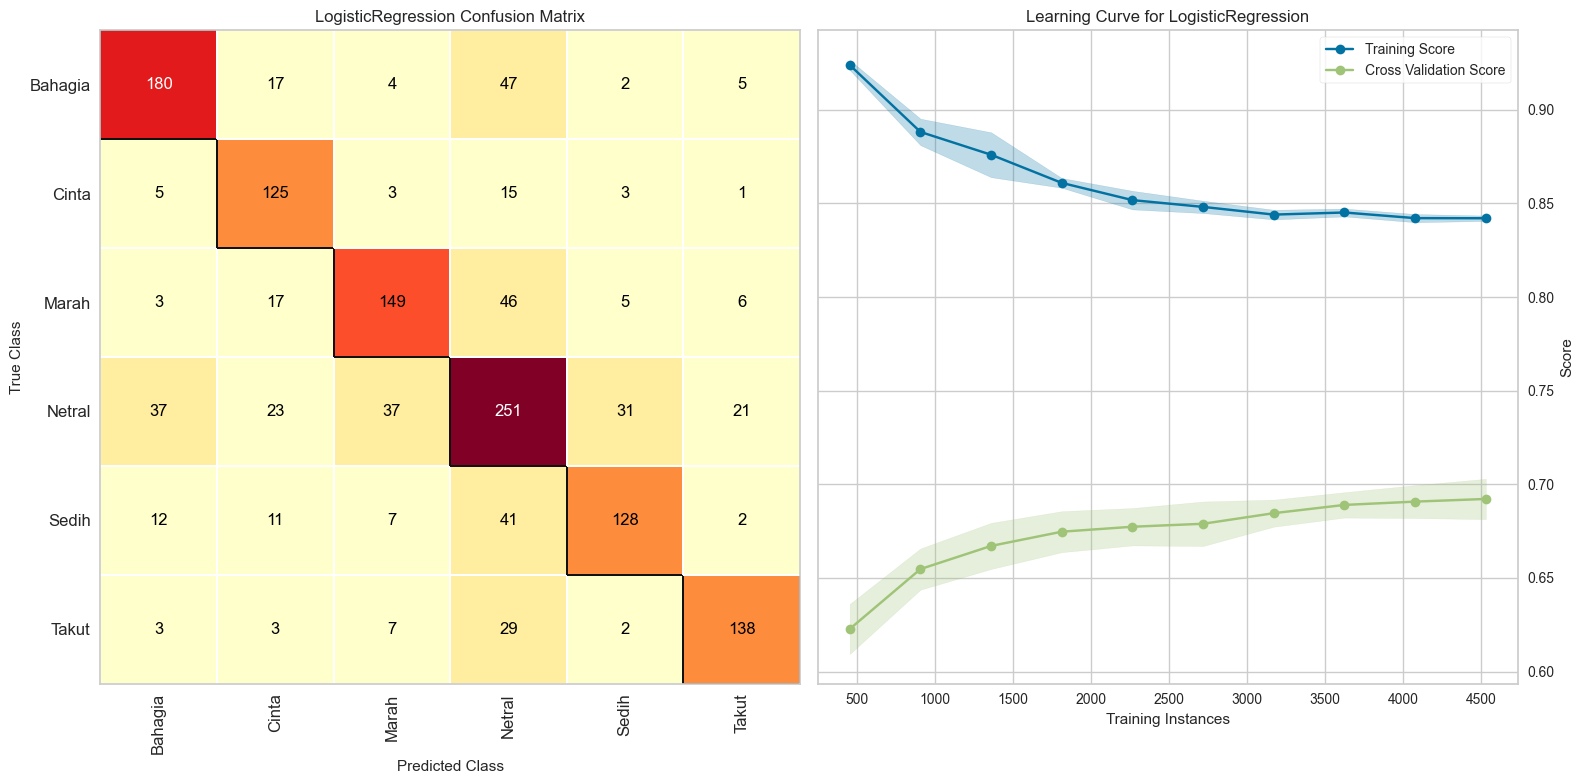




===================== Fine-Tuned Model (TPE Bayes Search) ================================


  0%|          | 0/25 [00:00<?, ?it/s]

Best parameters set found on development set:
{'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__max_iter': 878, 'clf__C': 4.177048267380822, 'clf__class_weight': None}
Best score:
0.7112336615321281
 
---- Refit Using CV ------
Train Scores:  [0.96621771 0.96599691 0.96754967 0.96688742 0.96710817]
Validation Scores:  [0.71050309 0.70697264 0.71819788 0.70053004 0.71996466]
Mean Train Scores:  0.966751974155272
Mean Validation Scores:  0.7112336615321281
Test Score:  0.7055084745762712


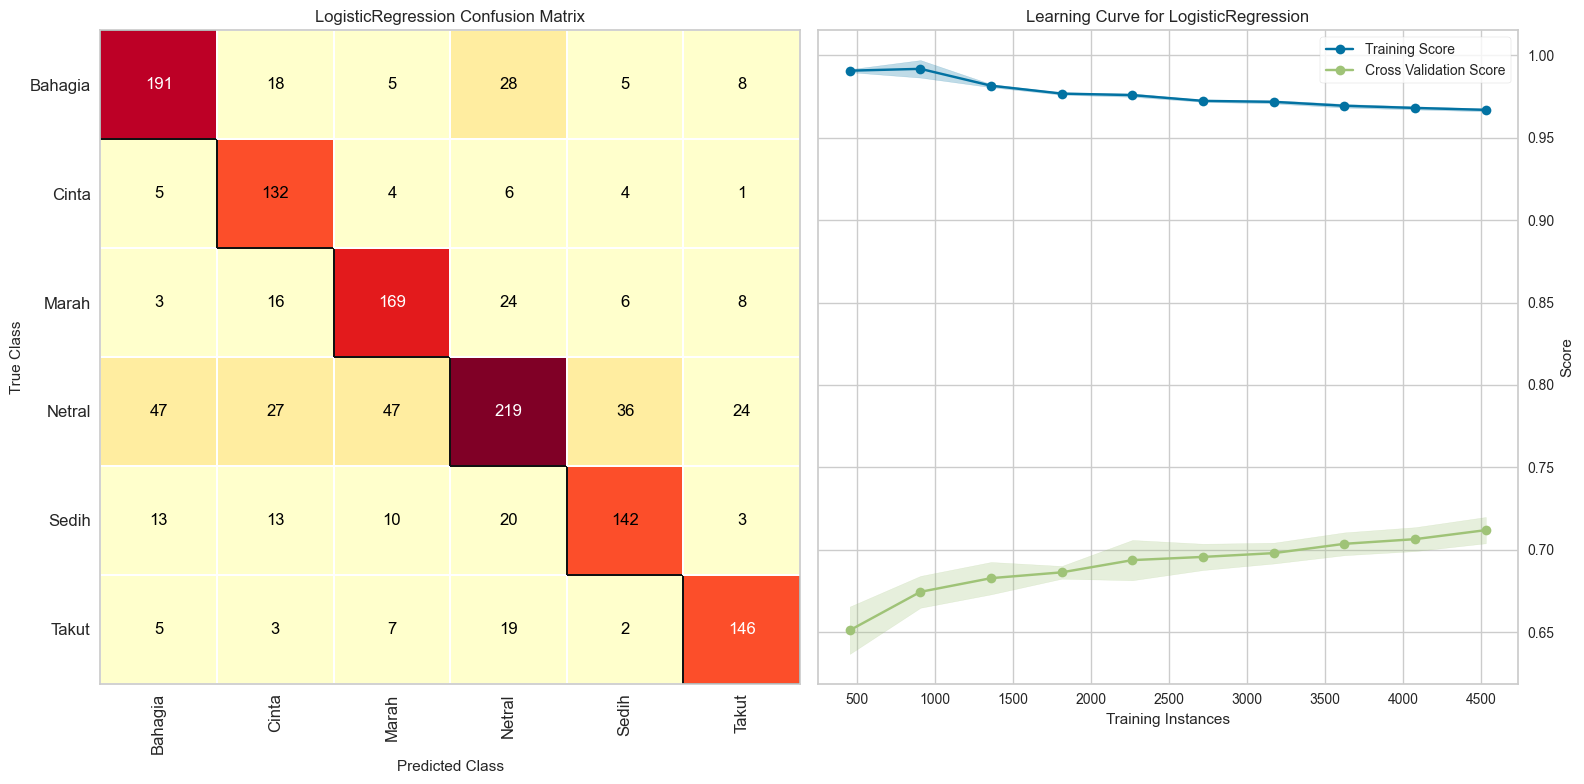

wandb: 
wandb: Plotting lr_tfidf.
wandb: WARNING 2-dimensional feature importances array passed to plot_feature_importances. 2-dimensional and higher feature importances arrays are not currently supported. These importances will not be plotted.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [89]:
def lr_objective(trial):
    # Define the hyperparameters to tune
    ngram_range = trial.suggest_categorical('tfidf__ngram_range', [(1, 1), (1, 2)])
    use_idf = trial.suggest_categorical('tfidf__use_idf', [True, False])
    norm = trial.suggest_categorical('tfidf__norm', ['l1', 'l2'])
    params = {
        'max_iter': trial.suggest_int('clf__max_iter', 100, 1000),
        'C': trial.suggest_float('clf__C', 1e-5, 1e2, log=True),        
        'class_weight': trial.suggest_categorical('clf__class_weight', ['balanced', None]),
    }
    
    # Create the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram_range, use_idf=use_idf, norm=norm)),
        ('clf', LogisticRegression(**params, n_jobs=-1))
    ])
    
    # Perform cross-validation
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(n_jobs=-1))
])

scikit_modeling(pipeline, lr_objective, X_train, X_test, y_train, y_test, "lr_tfidf", 25, conf_matrix_label, "accuracy")

### Multinomial Naive Bayes



===================== Baseline Model ================================
Train Scores:  [0.75314639 0.7511592  0.74944812 0.75298013 0.75364238]
Validation Scores:  [0.54104148 0.53574581 0.54681979 0.51678445 0.55123675]
Mean Train Scores:  0.7520752452797449
Mean Validation Scores:  0.5383256559557633
Test Score:  0.5388418079096046


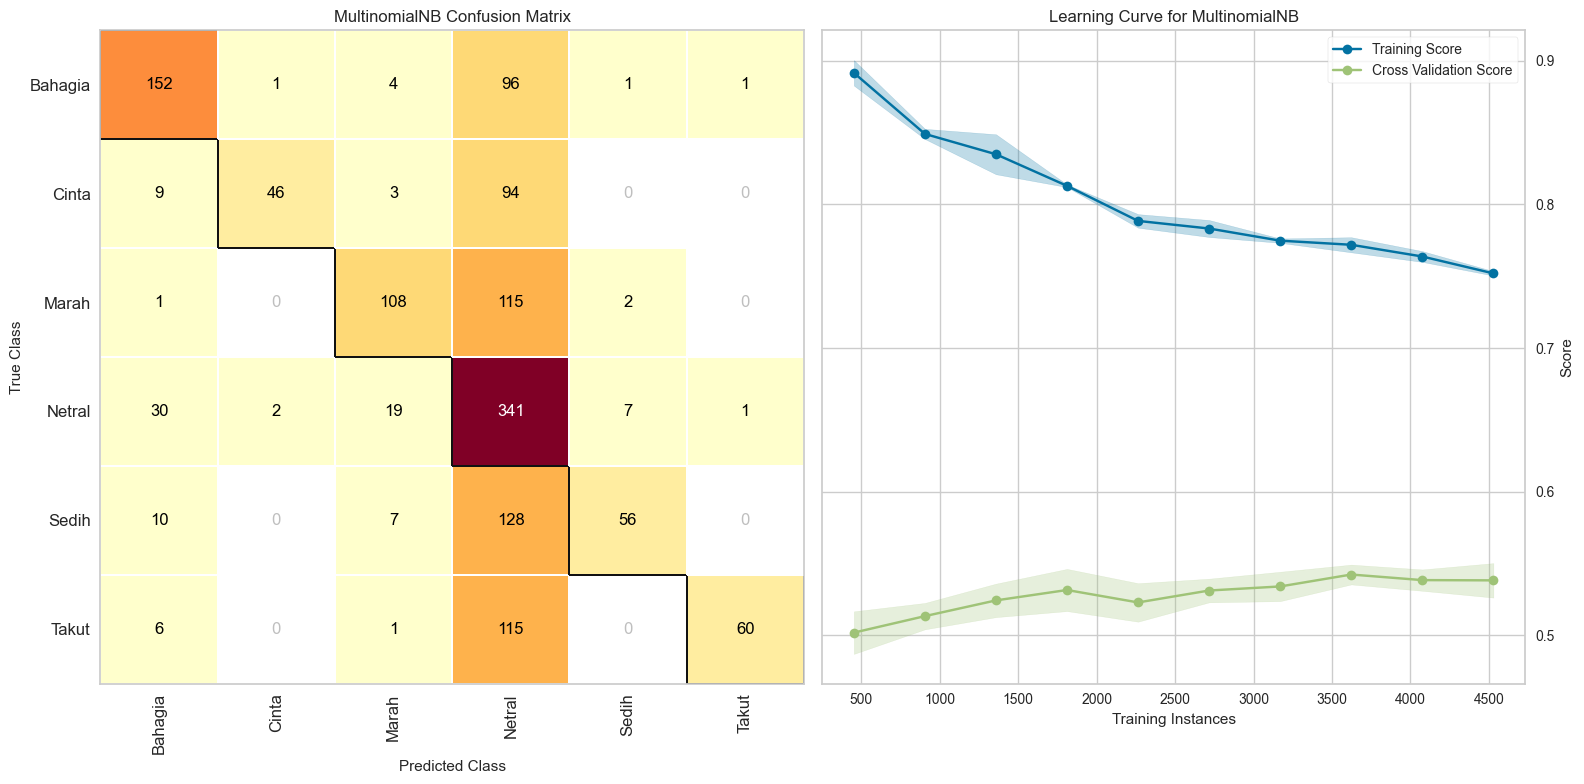




===================== Fine-Tuned Model (TPE Bayes Search) ================================


  0%|          | 0/20 [00:00<?, ?it/s]

Best parameters set found on development set:
{'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__alpha': 0.08262160327074239}
Best score:
0.6455295519259978
 
---- Refit Using CV ------
Train Scores:  [0.97814087 0.98056966 0.97836645 0.9790287  0.98189845]
Validation Scores:  [0.66107679 0.64165931 0.64664311 0.63780919 0.64045936]
Mean Train Scores:  0.9796008260720586
Mean Validation Scores:  0.6455295519259978
Test Score:  0.6532485875706214


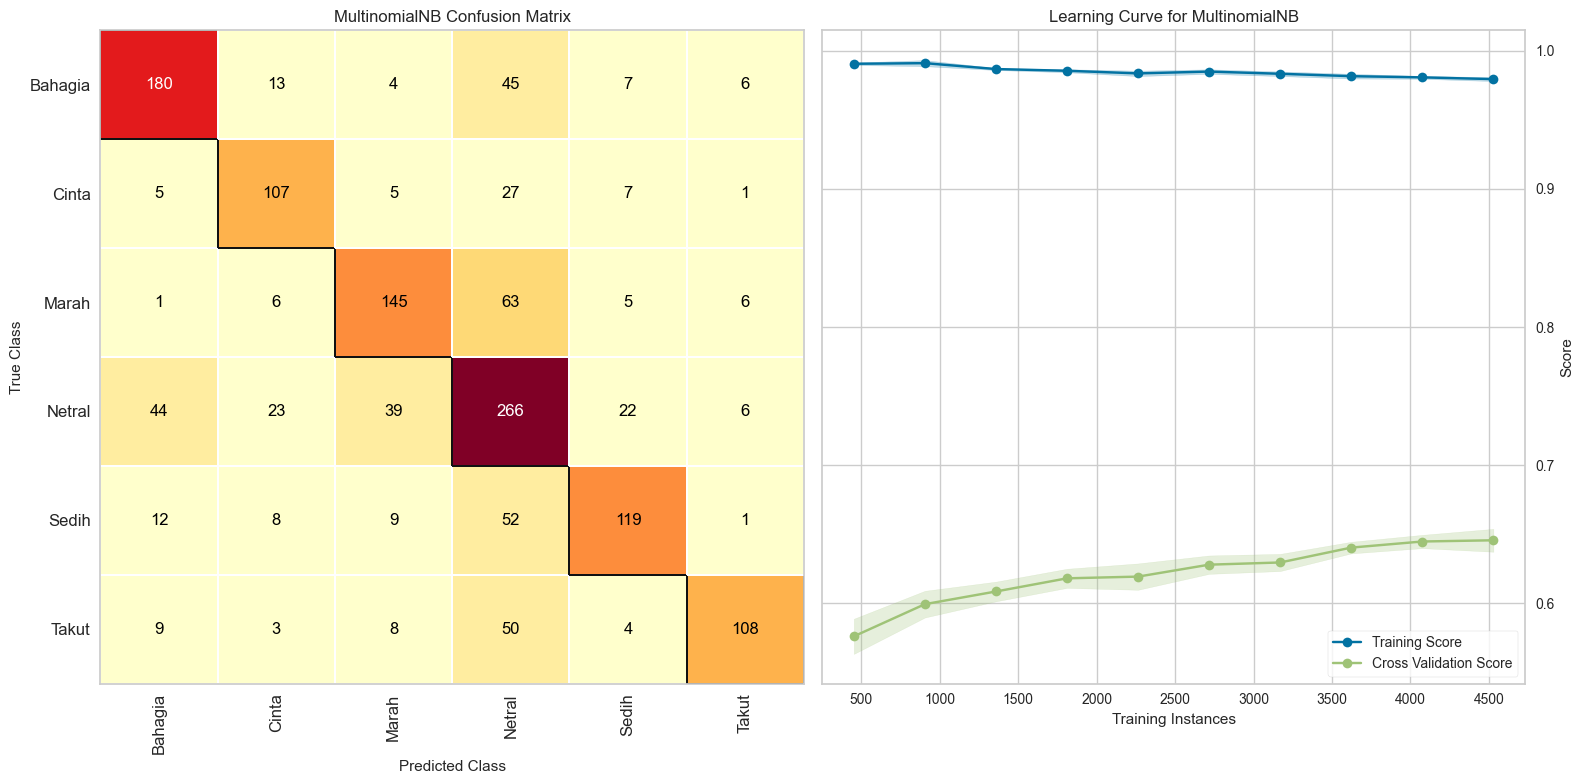

wandb: 
wandb: Plotting mnb_tfidf.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [21]:
def mnb_objective(trial):
    # Define the hyperparameters to tune
    ngram_range = trial.suggest_categorical('tfidf__ngram_range', [(1, 1), (1, 2)])
    use_idf = trial.suggest_categorical('tfidf__use_idf', [True, False])
    norm = trial.suggest_categorical('tfidf__norm', ['l1', 'l2'])
    alpha = trial.suggest_float('clf__alpha', 0.01, 1.0, log=True)

    # Create the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram_range, use_idf=use_idf, norm=norm)),
        ('clf', MultinomialNB(alpha=alpha))
    ])

    # Perform cross-validation
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

scikit_modeling(pipeline, mnb_objective, X_train, X_test, y_train, y_test, "mnb_tfidf", 20, conf_matrix_label, "accuracy")

### Complement Naive Bayes




===================== Baseline Model ================================
Train Scores:  [0.90262751 0.90439391 0.90419426 0.90441501 0.90110375]
Validation Scores:  [0.6407767  0.62930274 0.62367491 0.61219081 0.63957597]
Mean Train Scores:  0.903346888362805
Mean Validation Scores:  0.6291042262482106
Test Score:  0.6384180790960452


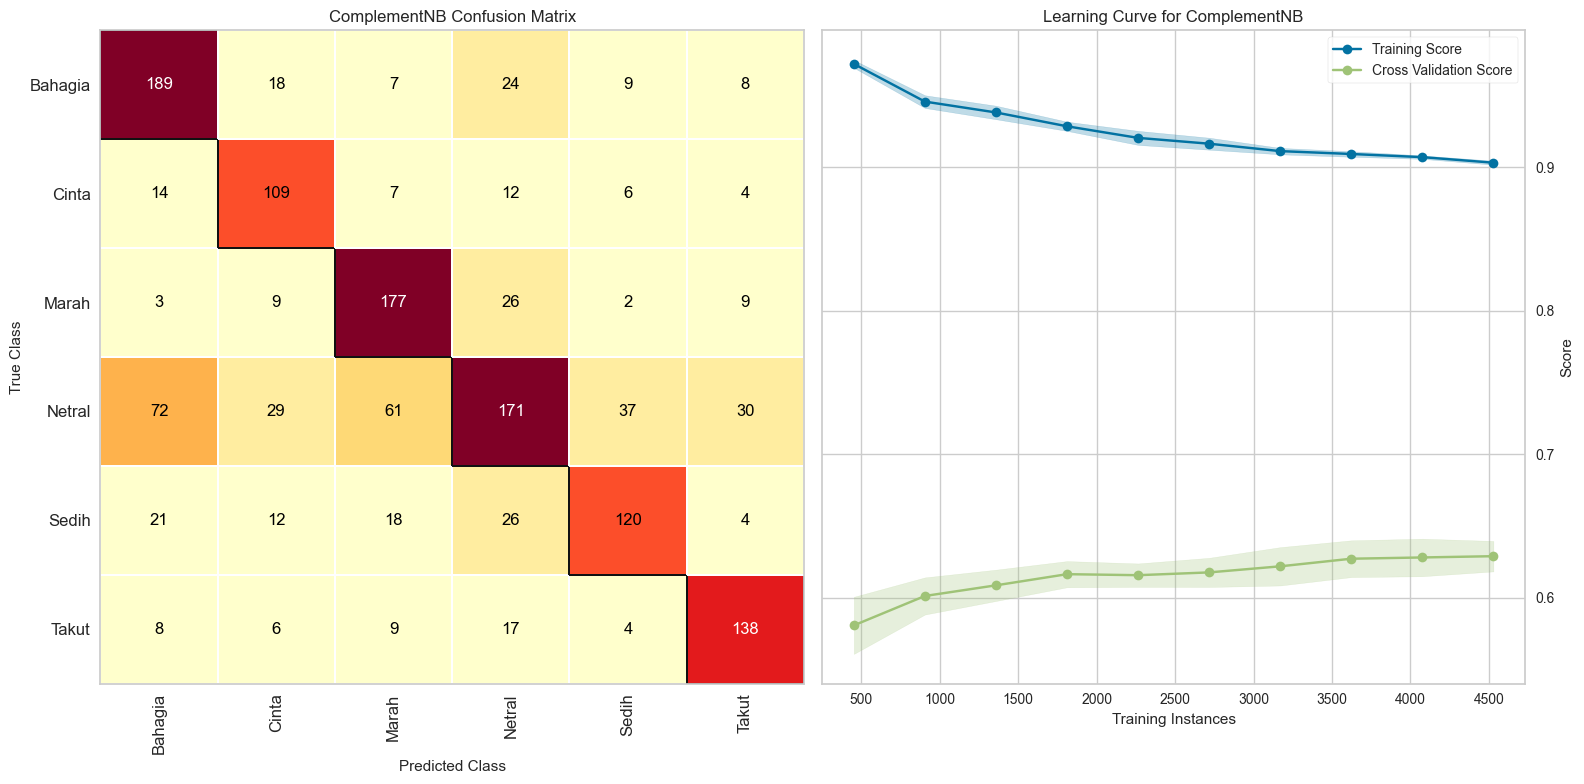




===================== Fine-Tuned Model (TPE Bayes Search) ================================


  0%|          | 0/20 [00:00<?, ?it/s]

Best parameters set found on development set:
{'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__alpha': 0.9394973828851984, 'clf__norm': False}
Best score:
0.6854474970293695
 
---- Refit Using CV ------
Train Scores:  [0.9366306  0.94038419 0.93686534 0.93951435 0.94128035]
Validation Scores:  [0.68932039 0.67784643 0.68639576 0.6704947  0.70318021]
Mean Train Scores:  0.938934967540554
Mean Validation Scores:  0.6854474970293695
Test Score:  0.6850282485875706


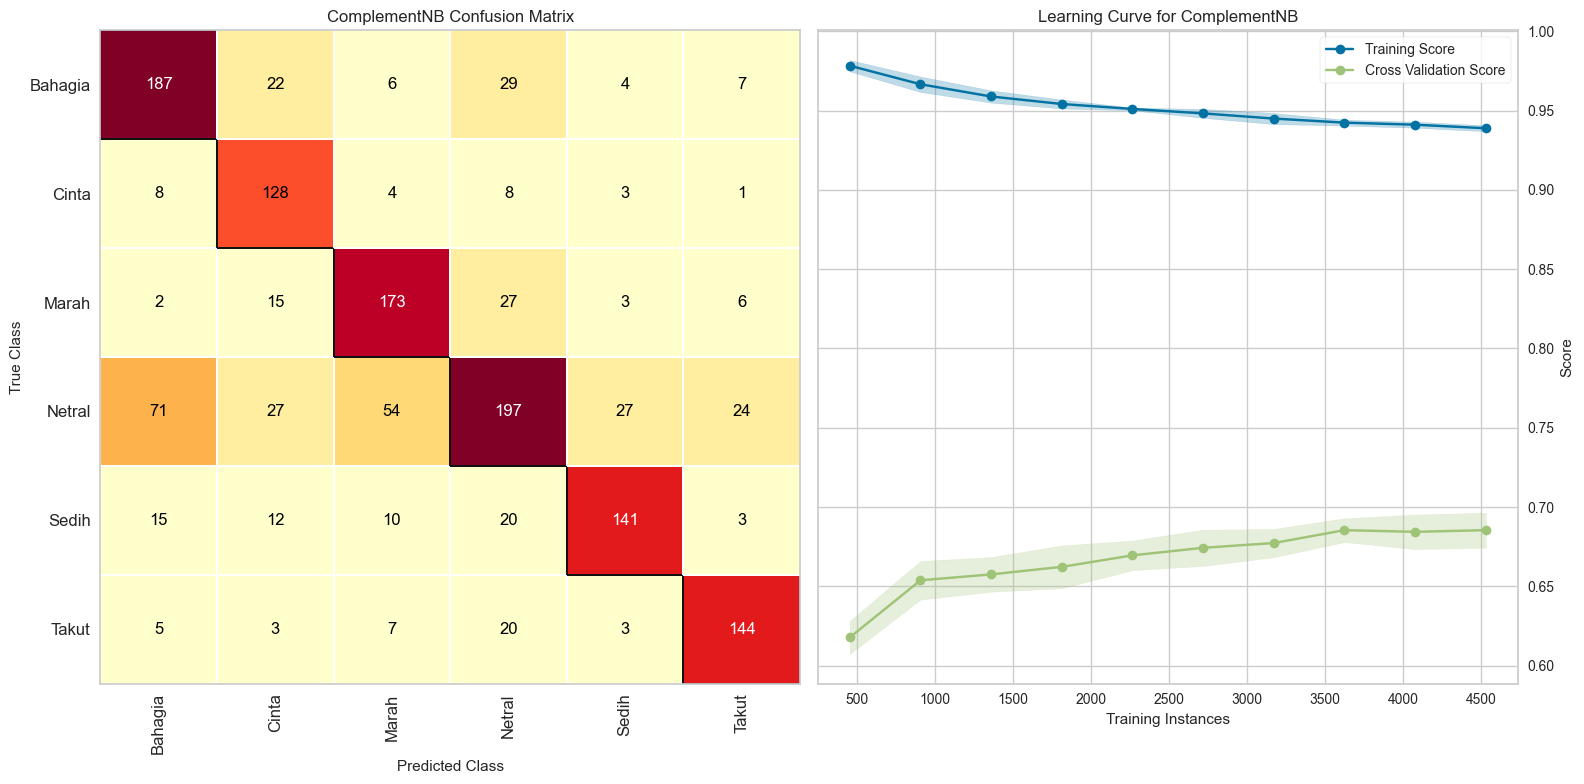

wandb: 
wandb: Plotting cnb_tfidf.
wandb: WARNING 2-dimensional feature importances array passed to plot_feature_importances. 2-dimensional and higher feature importances arrays are not currently supported. These importances will not be plotted.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [20]:
def cnb_objective(trial):
    # Define the hyperparameters to tune
    ngram_range = trial.suggest_categorical('tfidf__ngram_range', [(1, 1), (1, 2)])
    use_idf = trial.suggest_categorical('tfidf__use_idf', [True, False])
    norm = trial.suggest_categorical('tfidf__norm', ['l1', 'l2'])
    alpha = trial.suggest_float('clf__alpha', 0.01, 1.0, log=True)
    cnb_norm = trial.suggest_categorical('clf__norm', [True, False])
    
    # Create the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram_range, use_idf=use_idf, norm=norm)),
        ('clf', ComplementNB(alpha=alpha, norm=cnb_norm))
    ])
    
    # Perform cross-validation
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', ComplementNB())
])

scikit_modeling(pipeline, cnb_objective, X_train, X_test, y_train, y_test, "cnb_tfidf", 20, conf_matrix_label, "accuracy")

### SVC 



===================== Baseline Model ================================
Train Scores:  [0.95539854 0.95539854 0.95231788 0.95518764 0.95562914]
Validation Scores:  [0.67255075 0.67431598 0.69611307 0.67402827 0.69081272]
Mean Train Scores:  0.9547863486571944
Mean Validation Scores:  0.6815641578223485
Test Score:  0.6913841807909604


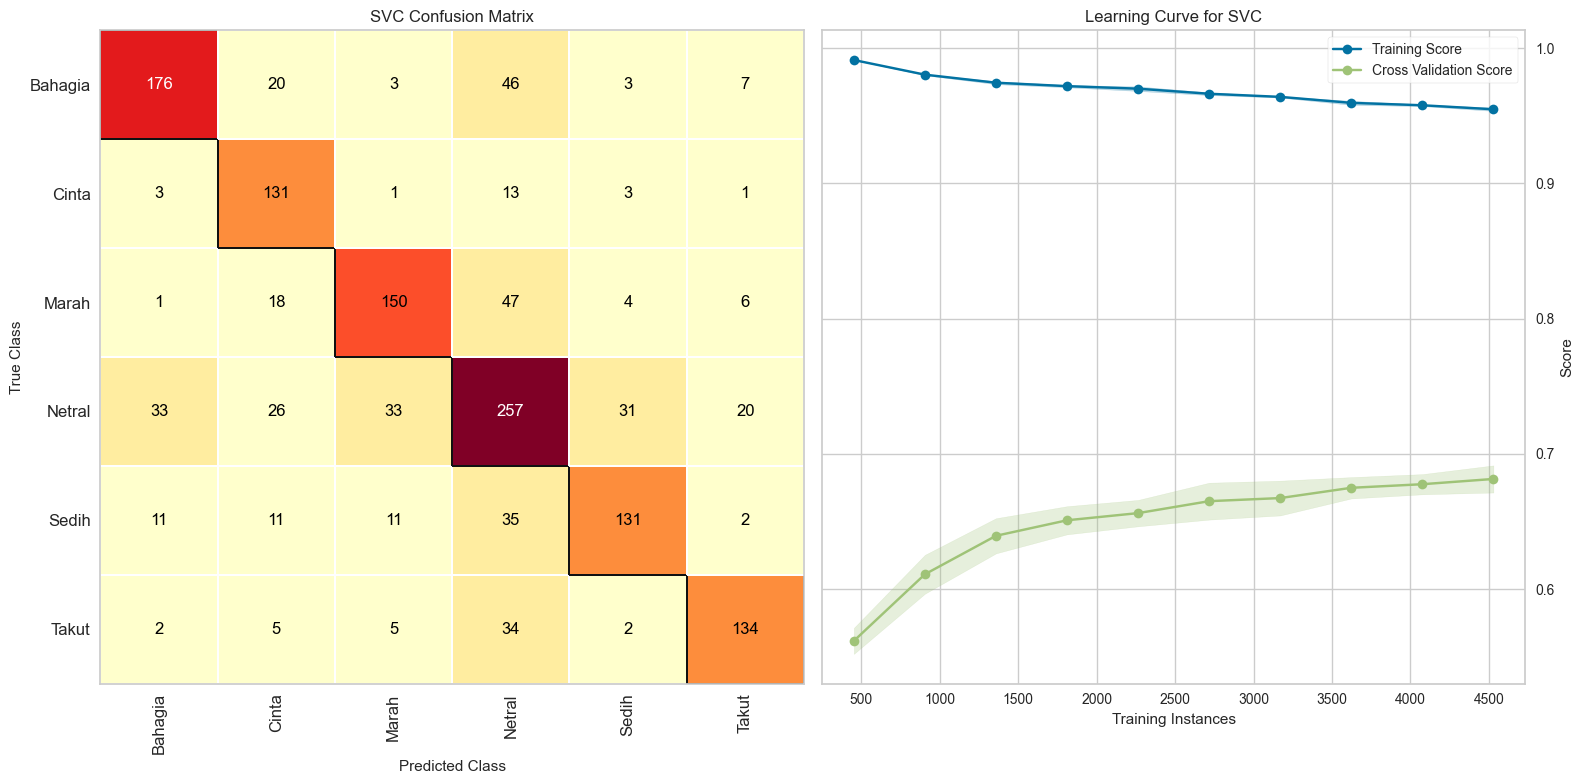




===================== Fine-Tuned Model (TPE Bayes Search) ================================


  0%|          | 0/25 [00:00<?, ?it/s]

Best parameters set found on development set:
{'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True, 'tfidf__norm': 'l1', 'clf__C': 1245.9577503976252, 'clf__kernel': 'sigmoid', 'clf__shrinking': True, 'clf__tol': 1.0454027406947802e-05, 'clf__class_weight': 'balanced', 'clf__gamma': 0.00446347734644798}
Best score:
0.6854504598629612
 
---- Refit Using CV ------
Train Scores:  [0.7798631  0.78317509 0.77660044 0.78498896 0.77593819]
Validation Scores:  [0.67519859 0.67519859 0.70318021 0.67137809 0.70229682]
Mean Train Scores:  0.7801131584193499
Mean Validation Scores:  0.6854504598629612
Test Score:  0.6701977401129944


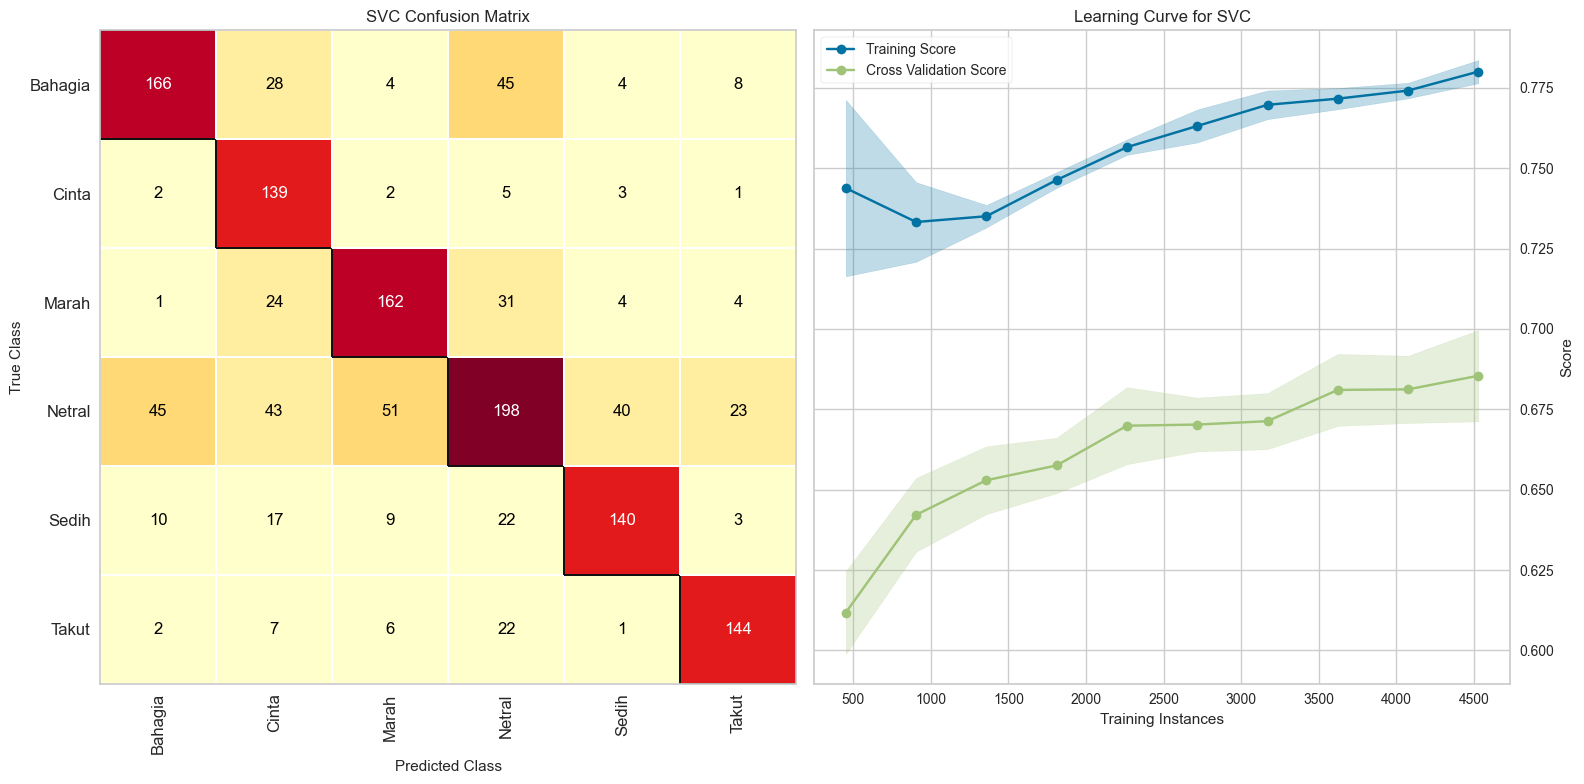

wandb: 
wandb: Plotting svc_tfidf.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [90]:
def svc_objective(trial):
    # Define the hyperparameters to tune
    ngram_range = trial.suggest_categorical('tfidf__ngram_range', [(1, 1), (1, 2)])
    use_idf = trial.suggest_categorical('tfidf__use_idf', [True, False])
    norm = trial.suggest_categorical('tfidf__norm', ['l1', 'l2'])
    params = {
        'C': trial.suggest_float('clf__C', 1e-5, 1e5, log=True),
        'kernel': trial.suggest_categorical('clf__kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'shrinking': trial.suggest_categorical('clf__shrinking', [True, False]),
        'tol': trial.suggest_float('clf__tol', 1e-5, 1e-2, log=True),
        'class_weight': trial.suggest_categorical('clf__class_weight', ['balanced', None])
    }

    # Conditional parameters
    if params['kernel'] == 'poly':
        params['degree'] = trial.suggest_int('clf__degree', 2, 5)
    if params['kernel'] in ['rbf', 'poly', 'sigmoid']:
        params['gamma'] = trial.suggest_loguniform('clf__gamma', 1e-5, 1e2)
        
    # Create the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram_range, use_idf=use_idf, norm=norm)),
        ('clf', SVC(**params, probability=True))
    ])
    
    # Perform cross-validation
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(probability=True))
])

scikit_modeling(pipeline, svc_objective, X_train, X_test, y_train, y_test, "svc_tfidf", 25, conf_matrix_label, "accuracy")

### Random Forest (Bagging)


===================== Baseline Model ================================
Train Scores:  [0.99205123 0.99183043 0.99139073 0.99139073 0.99403974]
Validation Scores:  [0.69285084 0.67519859 0.71113074 0.69611307 0.71201413]
Mean Train Scores:  0.9921405687263392
Mean Validation Scores:  0.6974614753663777
Test Score:  0.7048022598870056


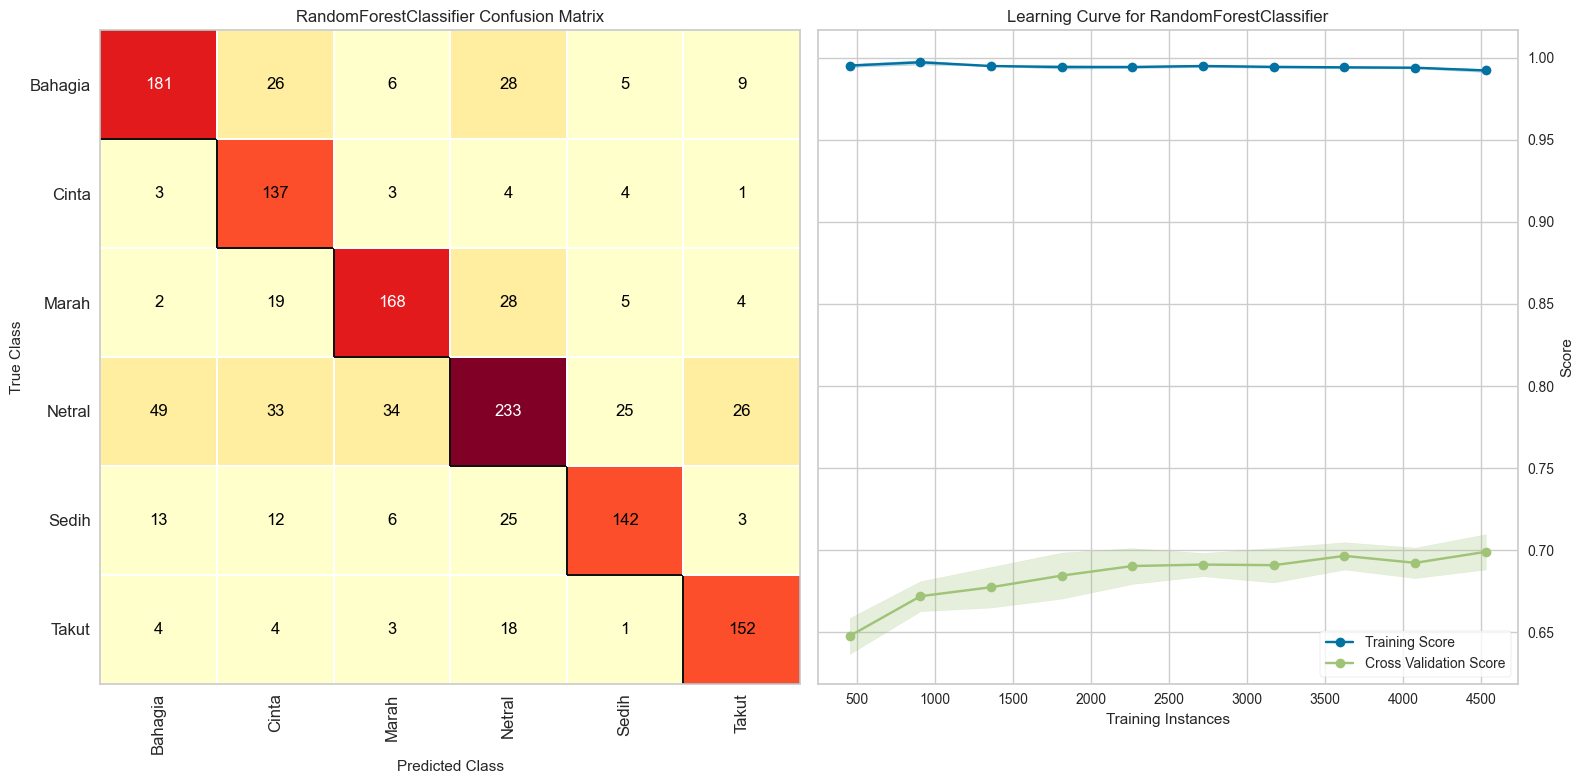




===================== Fine-Tuned Model (TPE Bayes Search) ================================


  0%|          | 0/20 [00:00<?, ?it/s]

Best parameters set found on development set:
{'tfidf__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l1', 'clf__n_estimators': 695, 'clf__max_depth': 21, 'clf__min_samples_split': 0.19936310460402706, 'clf__min_samples_leaf': 13, 'clf__max_features': 'sqrt', 'clf__class_weight': 'balanced_subsample'}
Best score:
0.6730882706096264
 
---- Refit Using CV ------
Train Scores:  [0.6884522  0.69353058 0.69271523 0.699117   0.68565121]
Validation Scores:  [0.65931156 0.66460724 0.6934629  0.65989399 0.66342756]
Mean Train Scores:  0.6918932442727442
Mean Validation Scores:  0.6681406503887551
Test Score:  0.66454802259887


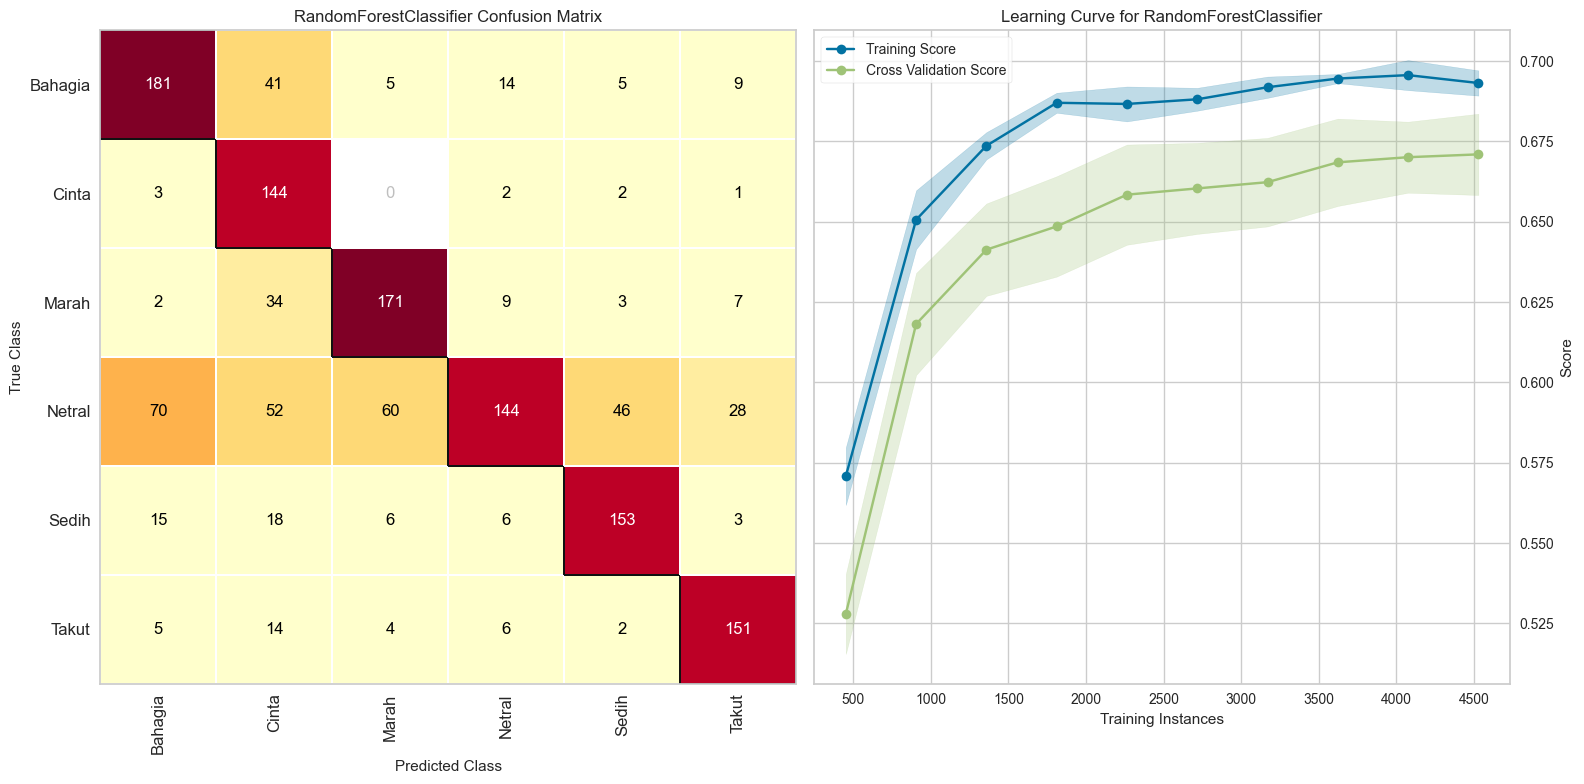

wandb: 
wandb: Plotting rf_tfidf.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [91]:
def rf_objective(trial):
    # Define the hyperparameters to tune
    ngram_range = trial.suggest_categorical('tfidf__ngram_range', [(1, 1), (1, 2)])
    use_idf = trial.suggest_categorical('tfidf__use_idf', [True, False])
    norm = trial.suggest_categorical('tfidf__norm', ['l1', 'l2'])
    params = {
        'n_estimators': trial.suggest_int('clf__n_estimators', 10, 1000, log=True),
        'max_depth': trial.suggest_int('clf__max_depth', 1, 100),
        'min_samples_split': trial.suggest_float('clf__min_samples_split', 0.01, 1, log=True),
        'min_samples_leaf': trial.suggest_int('clf__min_samples_leaf', 1, 16),
        'max_features': trial.suggest_categorical('clf__max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('clf__class_weight', ['balanced', 'balanced_subsample', None])
    }
    
    # Create the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram_range, use_idf=use_idf, norm=norm)),
        ('clf', RandomForestClassifier(**params, n_jobs=-1))
    ])
    
    # Perform cross-validation
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1))
])

scikit_modeling(pipeline, rf_objective, X_train, X_test, y_train, y_test, "rf_tfidf", 20, conf_matrix_label, "accuracy")

### XGBOOST (Boosting)



===================== Baseline Model ================================
Train Scores:  [0.9068227  0.91565467 0.91324503 0.91302428 0.90618102]
Validation Scores:  [0.690203   0.68049426 0.6934629  0.68904594 0.68816254]
Mean Train Scores:  0.9109855398396499
Mean Validation Scores:  0.688273728398604
Test Score:  0.7111581920903954


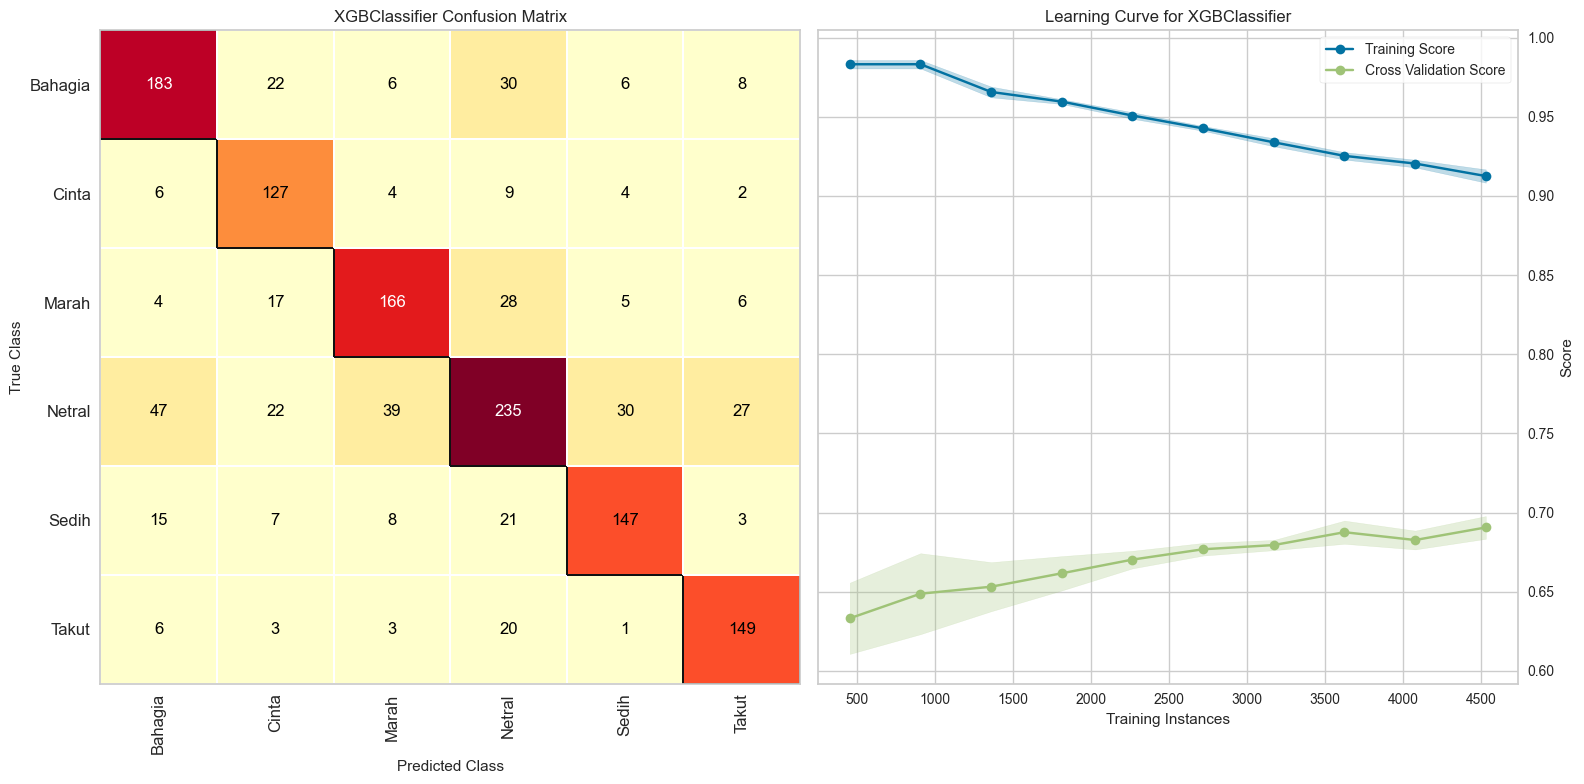




===================== Fine-Tuned Model (TPE Bayes Search) ================================


  0%|          | 0/5 [00:00<?, ?it/s]

Best parameters set found on development set:
{'tfidf__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l1', 'clf__n_estimators': 123, 'clf__max_depth': 8, 'clf__learning_rate': 0.052020232756245795, 'clf__subsample': 0.8962097902318571, 'clf__colsample_bytree': 0.9053324130000961, 'clf__min_child_weight': 6, 'clf__gamma': 0.4289831500492928, 'clf__reg_alpha': 2.01777895855424e-06, 'clf__reg_lambda': 6.977980543916345e-07}
Best score:
0.6967491477954959
 
---- Refit Using CV ------
Train Scores:  [0.78604548 0.78582469 0.79028698 0.78918322 0.78697572]
Validation Scores:  [0.70785525 0.69196823 0.71024735 0.68551237 0.68816254]
Mean Train Scores:  0.7876632172260493
Mean Validation Scores:  0.6967491477954959
Test Score:  0.6878531073446328


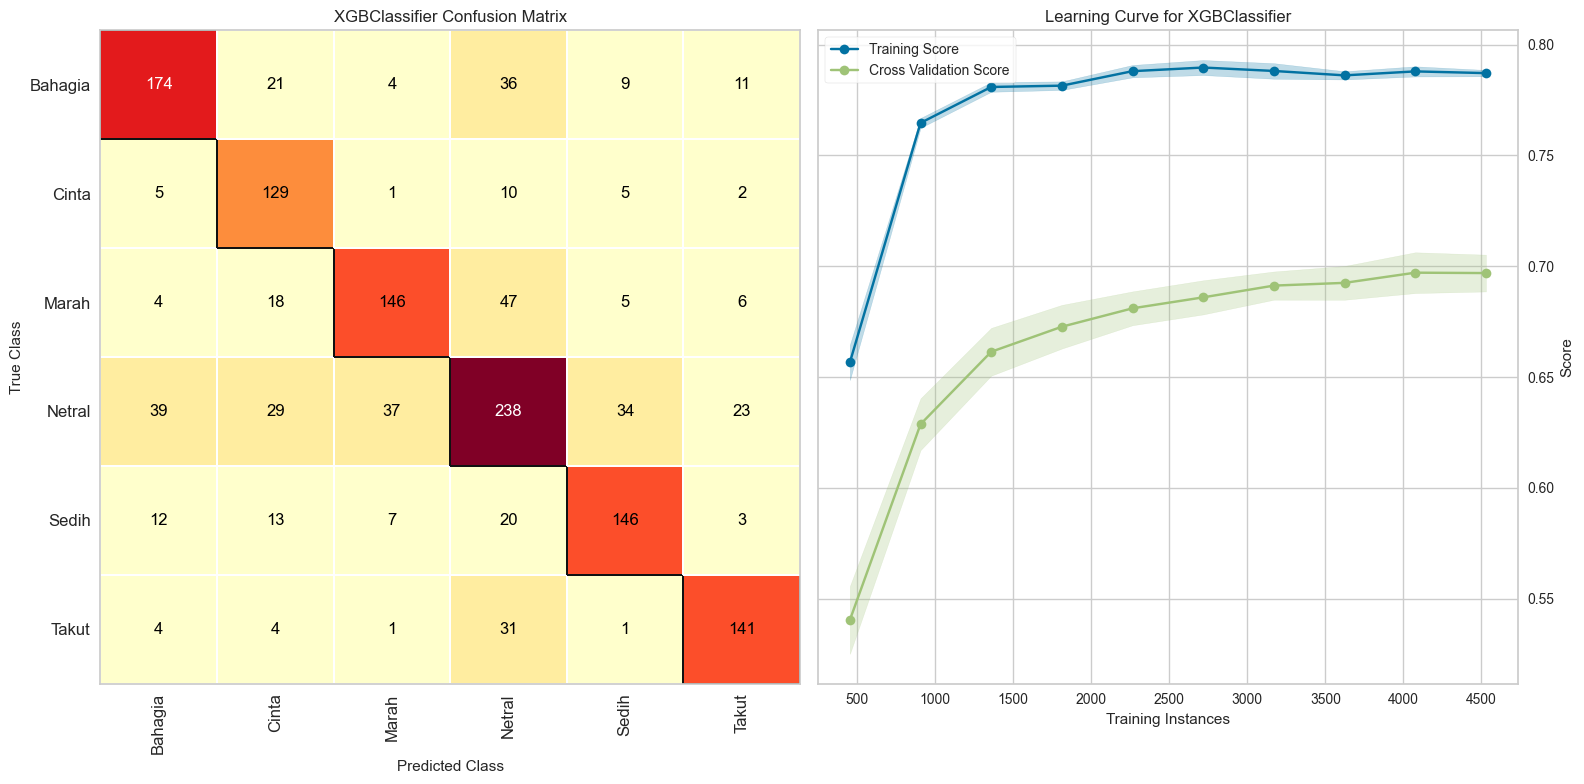

wandb: 
wandb: Plotting xgb_tfidf.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [26]:
def xgb_objective(trial):
    # Define the hyperparameters to tune
    ngram_range = trial.suggest_categorical('tfidf__ngram_range', [(1, 1), (1, 2)])
    use_idf = trial.suggest_categorical('tfidf__use_idf', [True, False])
    norm = trial.suggest_categorical('tfidf__norm', ['l1', 'l2'])
    params = {
        'n_estimators': trial.suggest_int('clf__n_estimators', 100, 10000, log=True),
        'max_depth': trial.suggest_int('clf__max_depth', 3, 10),
        'learning_rate': trial.suggest_float('clf__learning_rate', 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float('clf__subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('clf__colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('clf__min_child_weight', 1, 10),
        'gamma': trial.suggest_float('clf__gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('clf__reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('clf__reg_lambda', 1e-8, 1.0, log=True),
    }
        
    # Create the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram_range, use_idf=use_idf, norm=norm)),
        ('clf', xgb.XGBClassifier(
            **params,
            objective='multi:softmax',  
            num_class=len(np.unique(y)),
            device='cpu',
        ))
    ])
    
    # Perform cross-validation
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', xgb.XGBClassifier(
        objective='multi:softmax', 
        num_class=len(np.unique(y)),
        device='cpu',
    ))
])

scikit_modeling(pipeline, xgb_objective, X_train, X_test, y_train, y_test, "xgb_tfidf", 5, conf_matrix_label, "accuracy")

## Dense Features (Word Embedding)

---

### Feature Demonstration

<img src="assets/word-embedding-example.webp" alt="tf-idf" title="tf-idf formula" width="700" height="700">
Source: https://www.scaler.com/topics/tensorflow/tensorflow-word-embeddings
<br><br>

Kelebihan: 

- Dengan memproyeksikan kata-kata ke vektor kontinyu multi-dimensi. Teknik word embedding dapat menangkap semantik dari kata dengan cara merepresentasikan kata dengan makna yang mirip dengan vektor yang berdekatan.
- Dapat memanfaatkan embedding yang telah dilatih sebelummnya. Contoh: GloVe & FastText.


Kekurangan: 

- Ukuran yang relatif lebih besar, terutama untuk embedding pre-trained.
- Representasi yang dihasilkan lebih sulit untuk di-interpretasikan.

In [81]:
# Ref: https://deysusovan93.medium.com/from-traditional-to-modern-a-comprehensive-guide-to-text-representation-techniques-in-nlp-369946f67497
# from gensim.models import Word2Vec

# # Define the corpus (list of sentences)
# corpus = ["The cat jumped",
#         "The white tiger roared",
#         "Bird flying in the sky"]
# corpus=[sent.split(" ") for sent in corpus]
# # Train the Word2Vec model on the corpus
# model = Word2Vec(corpus, size=50, window=5, min_count=1, workers=2)

# # Get the vector representation of a word
# vector = model.wv["cat"]
# # Get the top-N most similar words to a given word
# similar_words = model.wv.most_similar("cat", topn=5)

In [82]:
# Ref: https://www.scaler.com/topics/tensorflow/tensorflow-word-embeddings/

# import tensorflow as tf
# from tensorflow.keras.layers import Embedding

# # Sample text data
# text_data = ["I love natural language processing", "Word embeddings are powerful"]

# # Tokenize the text and create a vocabulary
# tokenizer = tf.keras.layers.TextVectorization(max_tokens=100, output_mode="int")
# tokenizer.adapt(text_data)

# # Define the custom word embedding model
# embedding_dim = 50  # Adjust as needed
# embedding_model = tf.keras.Sequential([
#     Embedding(input_dim=len(tokenizer.get_vocabulary()), output_dim=embedding_dim),
# ])

# # Compile the model
# embedding_model.compile(optimizer="adam", loss="mse")

# # Train the custom word embedding model
# embedding_model.fit(tokenizer(text_data), epochs=10)

# # Extract word embeddings for specific words (e.g., "love" and "embeddings")
# word_indices = tokenizer(["love", "embeddings"]).numpy()
# embeddings = embedding_model.layers[0].get_weights()[0]

# # Print the word embeddings
# for i, word in enumerate(["love", "embeddings"]):
#     print(f"Word: {word}")
#     print(f"Embedding Vector: {embeddings[word_indices[i][0]]}\n")



### MLP 


#### Baseline

In [67]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_macro_recall',
    mode='max',
    patience=6,
    restore_best_weights=True
)

In [81]:
# Baseline model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, 
        output_dim=32
    ),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),    
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train_tf,
    y_train,
    epochs=150, 
    validation_data=(X_test_tf, y_test),
    verbose=2
#     callbacks=[early_stopping]
)

Epoch 1/150
177/177 - 1s - 6ms/step - accuracy: 0.2808 - loss: 1.8068 - val_accuracy: 0.2825 - val_loss: 1.7410
Epoch 2/150
177/177 - 0s - 1ms/step - accuracy: 0.2828 - loss: 1.7376 - val_accuracy: 0.2825 - val_loss: 1.7315
Epoch 3/150
177/177 - 0s - 1ms/step - accuracy: 0.2851 - loss: 1.7146 - val_accuracy: 0.2867 - val_loss: 1.6930
Epoch 4/150
177/177 - 0s - 1ms/step - accuracy: 0.3239 - loss: 1.6206 - val_accuracy: 0.4230 - val_loss: 1.5337
Epoch 5/150
177/177 - 0s - 1ms/step - accuracy: 0.4338 - loss: 1.4213 - val_accuracy: 0.5311 - val_loss: 1.3639
Epoch 6/150
177/177 - 0s - 1ms/step - accuracy: 0.5745 - loss: 1.1917 - val_accuracy: 0.5925 - val_loss: 1.1378
Epoch 7/150
177/177 - 0s - 1ms/step - accuracy: 0.6613 - loss: 1.0071 - val_accuracy: 0.5720 - val_loss: 1.1593
Epoch 8/150
177/177 - 0s - 1ms/step - accuracy: 0.7185 - loss: 0.8575 - val_accuracy: 0.6631 - val_loss: 0.9751
Epoch 9/150
177/177 - 0s - 1ms/step - accuracy: 0.7398 - loss: 0.7957 - val_accuracy: 0.6716 - val_loss:

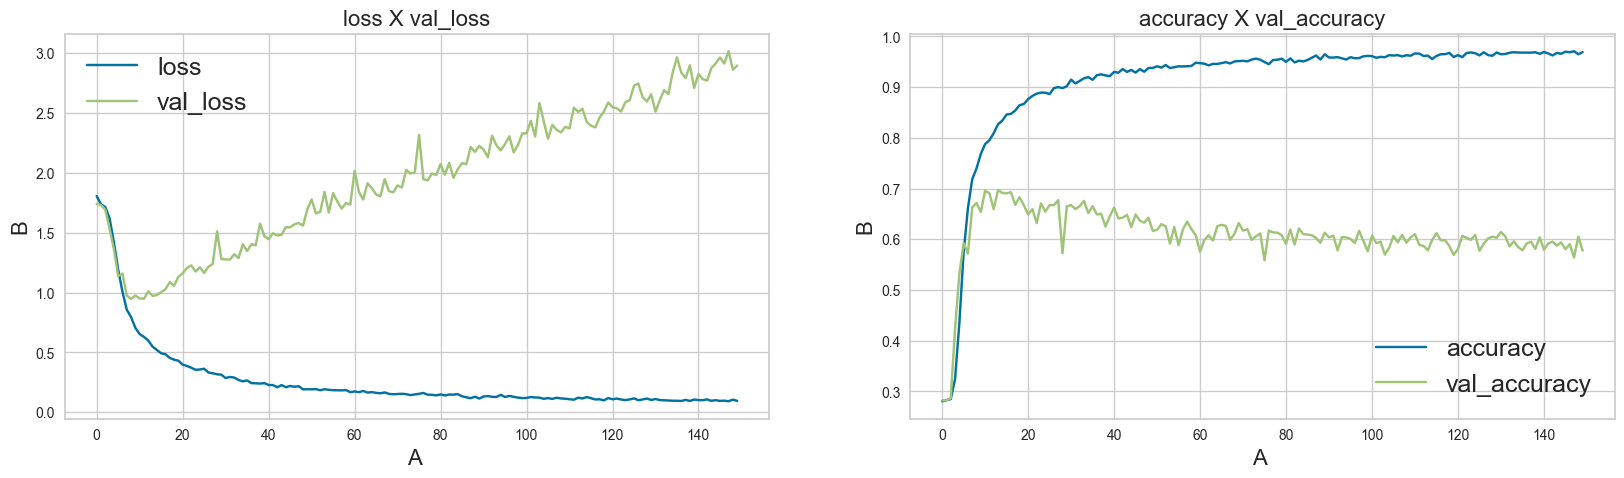

In [82]:
plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

#### With Pretrained Embedding

In [180]:
# Baseline model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False
    ),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),    
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    epochs=150, 
    validation_data=(X_test, y_test),
#     callbacks=[early_stopping]
)

Epoch 1/150
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1.8080 - macro_recall: 0.1193 - val_loss: 1.3057 - val_macro_recall: 0.1250
Epoch 2/150
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3331 - macro_recall: 0.1250 - val_loss: 1.2415 - val_macro_recall: 0.1250
Epoch 3/150
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2517 - macro_recall: 0.1251 - val_loss: 1.2141 - val_macro_recall: 0.1247
Epoch 4/150
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2047 - macro_recall: 0.1262 - val_loss: 1.1942 - val_macro_recall: 0.1273
Epoch 5/150
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1854 - macro_recall: 0.1294 - val_loss: 1.1792 - val_macro_recall: 0.1271
Epoch 6/150
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1544 - macro_recall: 0.1275 - val_loss: 1.1641 - val_macro_recall: 0.1285
Epoch 7/150
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1629 - macro_recall: 0.1294 - val_loss: 1.1475 - val_macro_recall: 0.1313
Epoch 8/150
101/101 ━━━━━━━━━━━━━━━━━━━━

### CNN

#### Baseline

#### With Pretrained Embeddign

### LSTM 



#### Baseline

In [78]:
del model_lstm

In [79]:
# LSTM Model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, 
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1)),    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax'),    
])


model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model_lstm.fit(
    X_train_tf,
    y_train,
    epochs=20, 
    validation_data=(X_test_tf, y_test),
    verbose=2
#     callbacks=[early_stopping]
)

Epoch 1/20
177/177 - 7s - 37ms/step - accuracy: 0.4659 - loss: 1.4832 - val_accuracy: 0.6702 - val_loss: 0.9735
Epoch 2/20
177/177 - 4s - 20ms/step - accuracy: 0.7572 - loss: 0.7447 - val_accuracy: 0.6758 - val_loss: 0.9354
Epoch 3/20
177/177 - 3s - 20ms/step - accuracy: 0.8455 - loss: 0.4898 - val_accuracy: 0.6801 - val_loss: 0.9967
Epoch 4/20
177/177 - 4s - 20ms/step - accuracy: 0.8919 - loss: 0.3500 - val_accuracy: 0.6660 - val_loss: 1.1466
Epoch 5/20
177/177 - 4s - 20ms/step - accuracy: 0.9182 - loss: 0.2625 - val_accuracy: 0.6448 - val_loss: 1.3164
Epoch 6/20
177/177 - 3s - 20ms/step - accuracy: 0.9313 - loss: 0.2168 - val_accuracy: 0.6419 - val_loss: 1.4424
Epoch 7/20
177/177 - 4s - 21ms/step - accuracy: 0.9454 - loss: 0.1854 - val_accuracy: 0.6292 - val_loss: 1.5363
Epoch 8/20
177/177 - 4s - 21ms/step - accuracy: 0.9532 - loss: 0.1558 - val_accuracy: 0.6215 - val_loss: 1.7106
Epoch 9/20
177/177 - 3s - 19ms/step - accuracy: 0.9520 - loss: 0.1528 - val_accuracy: 0.6116 - val_loss:

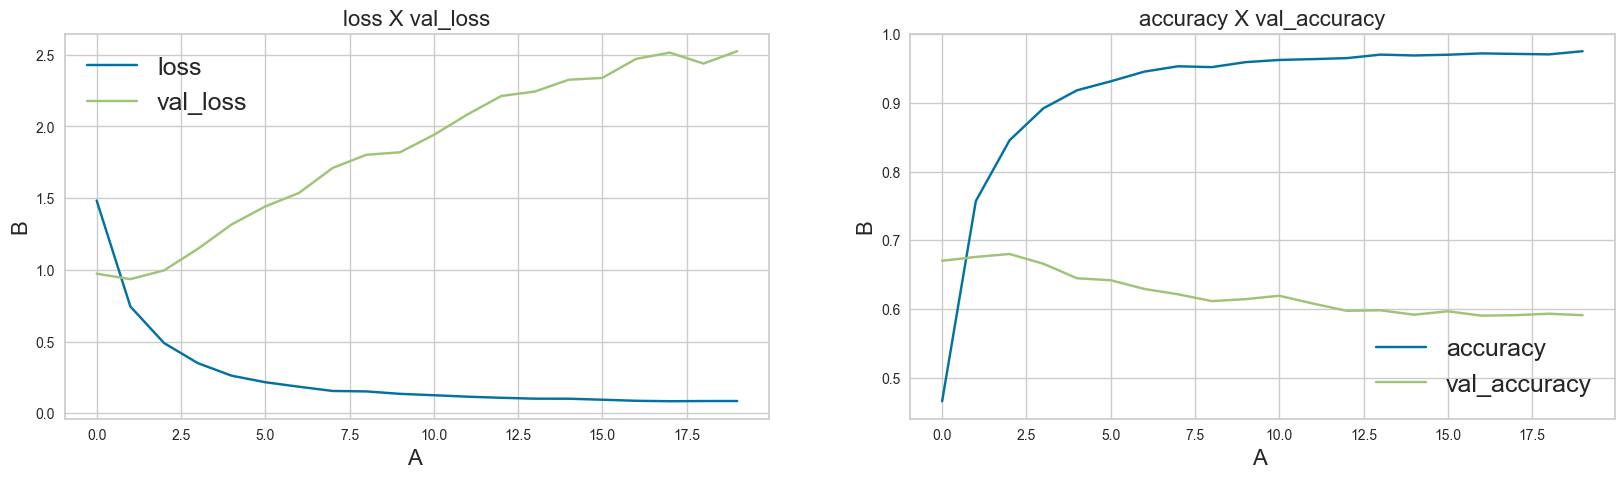

In [80]:
plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

#### With Pretrained Embedding

In [27]:
# LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)),    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),        
    tf.keras.layers.Conv1D(72, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1'),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax'),    
])


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=[MacroRecall()]
)

history = model.fit(
    X_train_res,
    y_train_res,
    epochs=50, 
    validation_data=(X_test, y_test),
#     callbacks=[early_stopping]
)

Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 247s 391ms/step - loss: 3.8339 - macro_recall: 0.1651 - val_loss: 1.8746 - val_macro_recall: 0.2485
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 228s 386ms/step - loss: 1.8956 - macro_recall: 0.2707 - val_loss: 1.5873 - val_macro_recall: 0.2881
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 228s 387ms/step - loss: 1.8227 - macro_recall: 0.3065 - val_loss: 1.4935 - val_macro_recall: 0.2772
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 228s 385ms/step - loss: 1.7474 - macro_recall: 0.3458 - val_loss: 1.6413 - val_macro_recall: 0.2869
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 226s 383ms/step - loss: 1.6953 - macro_recall: 0.3646 - val_loss: 1.4471 - val_macro_recall: 0.3327
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 229s 387ms/step - loss: 1.6400 - macro_recall: 0.3908 - val_loss: 1.2934 - val_macro_recall: 0.3254
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 226s 382ms/step - loss: 1.5526 - macro_recall: 0.4265 - val_loss: 1.3627 - val_macro_recall: 0.3092
Epoch 9/50
591/591 ━

In [182]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 80, 300)        │     1,952,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 80, 128)        │       186,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 80, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 78, 72)         │        27,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 39, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        26,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,985,878 (11.39 MB)

 Trainable params: 344,592 (1.31 MB)

 Non-trainable params: 1,952,100 (7.45 MB)

 Optimizer params: 689,186 (2.63 MB)

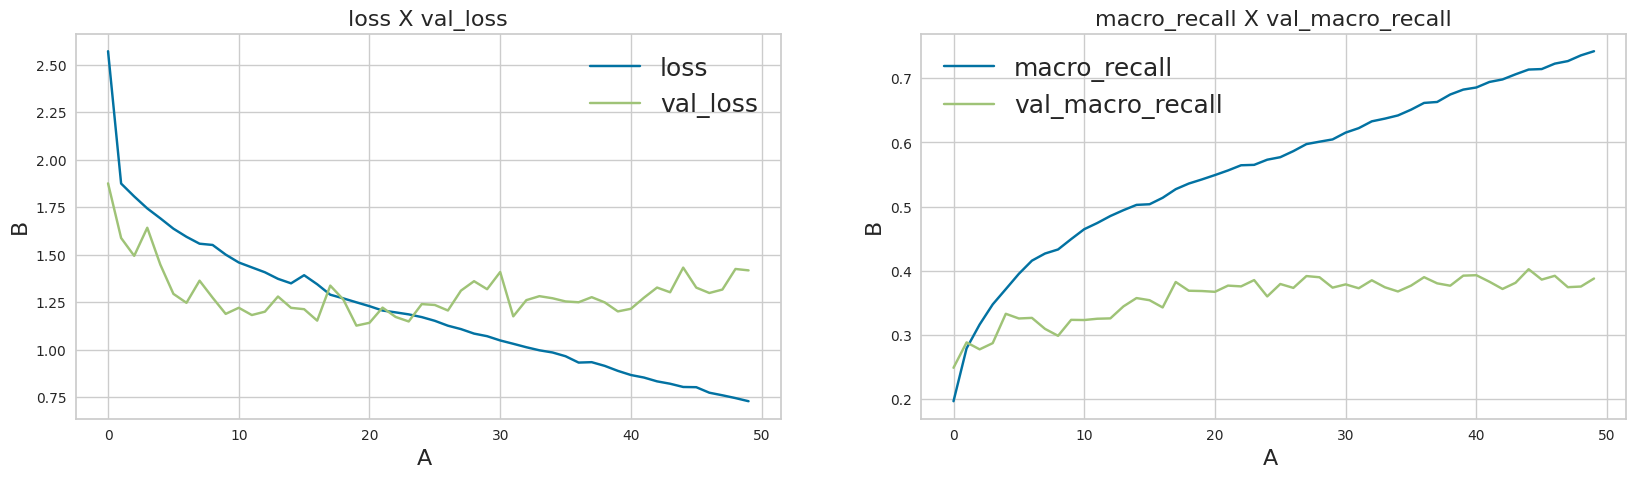

In [31]:
plot_learning_curves(history, [['loss', 'val_loss'], ['macro_recall', 'val_macro_recall']])

# *) Temporary Codes (Sandbox)

### Grid Search Vs Bayes Search (TPE based)

---

Fitting 5 folds for each of 80 candidates, totalling 400 fits

Best parameters set found on development set:
{'clf__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Best score:
0.28501019167125685
Train Scores:  [0.65464493 0.66376203 0.65057376 0.64659229 0.62744239]
Validation Scores:  [0.26469614 0.30300363 0.27662871 0.29537654 0.28534595]
Mean Train Scores:  0.6486030798198704
Mean Validation Scores:  0.28501019167125685
Score:  0.3244851849980014


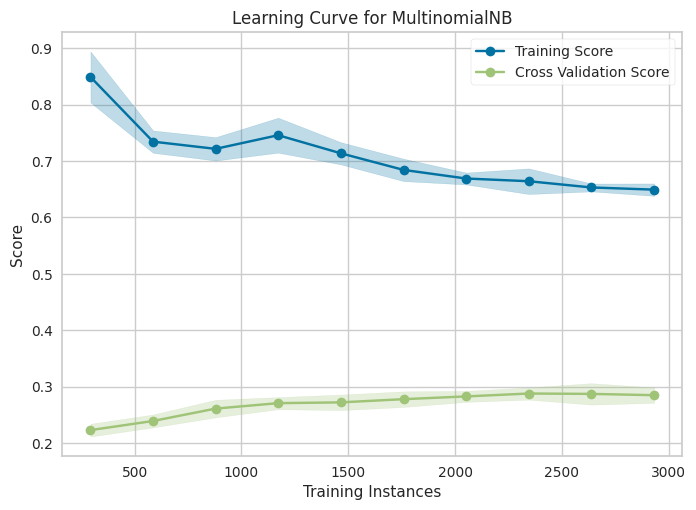

In [15]:
# ------------- GridSearchCV ---------------------

# # Fine-tuned model 
# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultinomialNB())
# ])

# # Fitting pipeline on a gridsearch
# param_grid = {
#     'vect__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2'),
#     'clf__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# }
# grid_search = GridSearchCV(pipeline, param_grid, scoring="balanced_accuracy", cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("\nBest parameters set found on development set:")
# print(grid_search.best_params_)
# print("Best score:")
# print(grid_search.best_score_)

# # Recheck the best estimator
# cv_result = cross_validate(grid_search.best_estimator_, X_train, y_train, scoring="balanced_accuracy", cv=5, return_train_score=True)
# print("Train Scores: ", cv_result["train_score"])
# print("Validation Scores: ", cv_result["test_score"])
# print("Mean Train Scores: ", np.mean(cv_result["train_score"]))
# print("Mean Validation Scores: ", np.mean(cv_result["test_score"]))

# # Evaluation with test data
# y_pred = grid_search.predict(X_test)
# balanced_acc = balanced_accuracy_score(y_test, y_pred)
# print("Score: ", balanced_acc)

# # viz
# visualizer = LearningCurve(grid_search.best_estimator_, cv=5, scoring='balanced_accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
# visualizer.fit(X_train, y_train)
# visualizer.show()
# plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Best parameters set found on development set:
{'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'clf__alpha': 0.02082290646794216}
Best score:
0.32178476428698727
Train Scores:  [0.83748821 0.87261253 0.85468235 0.86556089 0.85906856]
Validation Scores:  [0.32058744 0.32888806 0.31442917 0.32979662 0.31522254]
Mean Train Scores:  0.8578825097616193
Mean Validation Scores:  0.32178476428698727
Score:  0.371498835256554


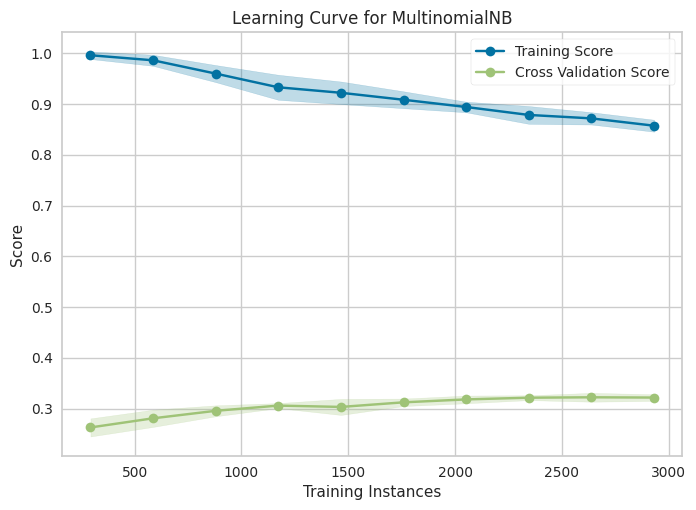

In [39]:
# ----------------------- Bayes Optimization --------------------

# Objective function for Optuna
# def objective(trial):
#     # Define the hyperparameters to tune
#     ngram_range = trial.suggest_categorical('vect__ngram_range', [(1, 1), (1, 2)])
#     use_idf = trial.suggest_categorical('tfidf__use_idf', [True, False])
#     norm = trial.suggest_categorical('tfidf__norm', ['l1', 'l2'])
#     alpha = trial.suggest_float('clf__alpha', 0.01, 1.0, log=True)
    
#     # Create the pipeline
#     pipeline = Pipeline([
#         ('vect', CountVectorizer(ngram_range=ngram_range)),
#         ('tfidf', TfidfTransformer(use_idf=use_idf, norm=norm)),
#         ('clf', MultinomialNB(alpha=alpha))
#     ])
    
#     # Perform cross-validation
#     score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
#     return score

# # Create the study and optimize
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

# # Print the best parameters and best score
# print("Best parameters set found on development set:")
# print(study.best_params)
# print("Best score:")
# print(study.best_value)

# # Re-check with CV (Result of Optuna)
# best_pipeline = Pipeline([
#     ('vect', CountVectorizer(ngram_range=study.best_params['vect__ngram_range'])),
#     ('tfidf', TfidfTransformer(use_idf=study.best_params['tfidf__use_idf'], norm=study.best_params['tfidf__norm'])),
#     ('clf', MultinomialNB(alpha=study.best_params['clf__alpha']))
# ])
# cv_result = cross_validate(best_pipeline, X_train, y_train, scoring="balanced_accuracy", cv=5, return_train_score=True)
# print("Train Scores: ", cv_result["train_score"])
# print("Validation Scores: ", cv_result["test_score"])
# print("Mean Train Scores: ", np.mean(cv_result["train_score"]))
# print("Mean Validation Scores: ", np.mean(cv_result["test_score"]))


# # Evaluation with test data
# best_pipeline.fit(X_train, y_train)
# y_pred = best_pipeline.predict(X_test)
# balanced_acc = balanced_accuracy_score(y_test, y_pred)
# print("Score: ", balanced_acc)

# # Create a learning curve display
# visualizer = LearningCurve(best_pipeline, cv=5, scoring='balanced_accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

# # Fit the visualizer (it fits the pipeline internally)
# visualizer.fit(X_train, y_train)
# visualizer.show()  # Save the plot to a file
# plt.show()

### Scikit Optimize BayesianSearchCV (Bayes Search Wrapper)

---

In [ ]:
# Scikit Optimize BayesianSearchCV

# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultinomialNB())
# ])

# # Define the parameter search space
# param_space = {
#     'vect__ngram_range': Categorical([(1, 1), (1, 2)]),  
#     'tfidf__use_idf': Categorical([True, False]),
#     'tfidf__norm': Categorical(['l1', 'l2']),    
#     'clf__alpha': Real(0.01, 1.0, prior='log-uniform')
# }

# # Create BayesSearchCV
# bayes_search = BayesSearchCV(
#     estimator=pipeline, 
#     search_spaces=param_space, 
#     cv=5, 
#     n_jobs=-1, 
#     verbose=1,
#     scoring="balanced_accuracy"
# )

# # Fit the Bayesian search
# bayes_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best parameters set found on development set:")
# print(bayes_search.best_params_)
# print("Best score:")
# print(bayes_search.best_score_)

### Checking Stratified K-fold Mechanism

---

In [90]:
# skf = StratifiedKFold(n_splits=5)
# for index, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
#     print("Fold: {}".format(index))
#     print("Train Len: {}, Test Len: {}".format(len(train_index), len(test_index)))
#     print("Value counts: ")
#     print(y_train.iloc[test_index].value_counts())
#     print(test_index)
#     print(" ")

Fold: 0
Train Len: 2932, Test Len: 734
Value counts: 
label_encoded
5    473
6     67
3     54
4     53
1     49
7     24
0     10
2      4
Name: count, dtype: int64
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  1

### Pre-processing Throwaway

----

In [63]:
# Testing flow
# p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.RESERVED)
# translator = GoogleTranslator(source="en",target="id")
# # Function
# def clean_text(text):
#     pattern_re = r"\[RE (.*?)\]"
#     pattern_mention = r"@[^\s]+"
#     pattern_hashtag = r"#[^\s]+"
#     pattern_symbols = r'[^A-Za-z\s]'
#     pattern_html_code = r"&[a-zA-Z0-9]+;"
    
#     print("Input: ", text) #debug    
#     # Removing mentions
#     text = re.sub(pattern_mention, "", text)
#     print("Mentions: ", text) #debug    
#     # Removing hashtags
#     text = re.sub(pattern_hashtag, "", text)    
#     print("Hashtags: ", text) #debug
#     # Removing html escape codes
#     text = re.sub(pattern_html_code, "", text) 
#     print("HTML: ", text) #debug       
#     # Removing RE pattern at the end of tweet
#     text = re.sub(pattern_re, "", text)
#     print("RE: ", text) #debug     
#     # Removing links, emoji, smiley
#     text = p.clean(text)
#     print("1st p clean: ", text) #debug    
#     # Removing symbols & numbers
#     text = re.sub(pattern_symbols, " ", text)
#     print("Symbol Num: ", text) #debug          
#     # Translating english words into indonesian & removing extra spaces
#     text = translator.translate(text)
#     print("Translated: ", text) #debug    
#     # Lowercasing
#     text = text.lower()
#     print("lowercase: ", text) #debug        
#     return text

# text = 'RT Rekam jejak si jago kata kata @alxlxg/dsgd.. Pulau sebira yg doesnt make any sense terletak dipinggiran ibu kota, penghuninya puluhan tahun hidup tanpa listrik dan air bersih, hanya dengan berkata" saat ini rakyat sebira menikmati semua yg berhak untuk mereka.. Desak Anies #AsalBukanPrabowo #AsalBukanPrabowo https://t.co/c3E8F1TRGw [RE NeiskaH]'
# # text = "RT Anak @dsljft/dfod Muda Indonesia,,, the future of this nation is in your hand. It's the time for change. Anies for President..sampaikan yg harus disampaikan kepada teman adu ide &amp; gagasan...tunjukan karya-karya Pak Anies untuk Perubahan Indonesia lebih baik lagi https://t.co/S9S9Kanr0z [RE Yurissa_Samosir]"
# textc = clean_text(text)
# print("\nRaw: ", text)
# print("")
# print("Final : ", textc)

In [64]:
# text = 'RT Rekam jejak si jago kata kata @alxlxg/dsgd.. Pulau sebira yg doesnt make any sense terletak dipinggiran ibu kota, penghuninya puluhan tahun hidup tanpa listrik dan air bersih, hanya dengan berkata" saat ini rakyat sebira menikmati semua yg berhak untuk mereka.. Desak Anies #AsalBukanPrabowo #AsalBukanPrabowo https://t.co/c3E8F1TRGw [RE NeiskaH]'
# for word in text.split():
#     print(translator.translate(word))

In [ ]:
# def clean_text_2_fold(text):
#     pattern_re = r"\[RE (.*?)\]"
#     pattern_mention = r"@[^\s]+"
#     pattern_hashtag = r"#[^\s]+"
#     pattern_symbols = r'[^A-Za-z\s]'
#     pattern_html_code = r"&[a-zA-Z0-9]+;"
    
#     # Removing mentions
#     text = re.sub(pattern_mention, "", text)
#     # Removing hashtags
#     text = re.sub(pattern_hashtag, "", text)    
#     # Removing html escape codes
#     text = re.sub(pattern_html_code, "", text) 
#     # Removing RE pattern at the end of tweet
#     text = re.sub(pattern_re, "", text)
#     # Removing links, emoji, smiley, reserved words
#     text = p.clean(text)
#     # Removing symbols & numbers
#     text = re.sub(pattern_symbols, " ", text)
#     # Translating english sentence into indonesian (sentence level)
#     text = translator.translate(text)
#     # Translating english words into indonesian (word level) --ON Progress
#     new_text = " "
#     for token in text.split():
#         new_text += translator.translate(token)
#         new_text += " "
#     text = new_text
#     # Performing additional cleaning (just in case)
#     text = p.clean(text)
#     # Lowercasing
#     text = text.lower()
#     return text